In [1]:
import os

from fastai.vision.all import *
from fastai.vision import *

import pandas as pd
import PIL

from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from src.classification.utils import image_classification_models

In [2]:
resize = Resize(128)

precision_macro_fastai = Precision(average='macro')
recall_macro_fastai = Recall(average='macro')
roc_auc_fastai = RocAuc()

# Custom transform
def custom_transform(size):
    return Resize(size, method="pad", pad_mode="zeros")


class RGB2HSV(Transform):
    def encodes(self, img: PILImage):
        return rgb2hsv(img)
    

item_tfms = custom_transform(size=128)
# batch_tfms = [
#         RGB2HSV(),
#         *aug_transforms(size=128, flip_vert=True, max_rotate=10),
#         Brightness(max_lighting=0.2, p=0.75),
#         Contrast(max_lighting=0.2, p=0.75),
#     ]

batch_tfms = [
        RGB2HSV(),
        *aug_transforms(size=128, flip_vert=True, max_rotate=10),
    ]

### Compare Different Models
In this section I will compare different Image classification models with the datasets created.
Classes are ordered as follow:
1. Amber
2. Clear
3. Cloudy
The order is determined by the order of folders in the dataset folder

In [3]:
import os

# iterate over each dataset in the datasets folder
balanced_datasets = "/home/etaylor/code_projects/thesis/classification_datasets/trichome_classification/balanced_datasets"
data_paths = [os.path.join(balanced_datasets, dataset) for dataset in os.listdir(balanced_datasets)]


In [6]:
# from fastai.vision.all import *
# from collections import Counter
# import os

# # Define your batch size
# batch_size = 64

# for dataset_path in data_paths:
#     train_path = os.path.join(dataset_path, "train")
#     val_path = os.path.join(dataset_path, "val")
#     test_path = os.path.join(dataset_path, "test")
    
#     # Print the class distribution from the folders
#     train_dist = Counter([os.path.basename(os.path.dirname(f)) for f in get_image_files(train_path)])
#     val_dist = Counter([os.path.basename(os.path.dirname(f)) for f in get_image_files(val_path)])
#     test_dist = Counter([os.path.basename(os.path.dirname(f)) for f in get_image_files(test_path)])
    
#     print(f"--------- Dataset: {os.path.basename(dataset_path)} ---------")
#     print("Class Distribution from folders:")
#     print(f"Training Class Distribution: {train_dist}")
#     print(f"Validation Class Distribution: {val_dist}")
#     print(f"Test Class Distribution: {test_dist}")
    
#     # Define dataloaders
#     dls = ImageDataLoaders.from_folder(
#         path=dataset_path,
#         item_tfms=Resize(128),
#         bs=batch_size,
#         valid_pct=None  # Ensure no additional splitting
#     )

#     # Create the test DataLoader with the same transformations
#     test_files = get_image_files(test_path)
#     test_dl = dls.test_dl(test_files, with_labels=True)
    
#     # Retrieve datasets
#     train_ds = dls.train_ds
#     valid_ds = dls.valid_ds
#     test_ds = test_dl.dataset
    
#     # Decode labels
#     train_labels = [train_ds.decode(train_ds[i])[1] for i in range(len(train_ds))]
#     valid_labels = [valid_ds.decode(valid_ds[i])[1] for i in range(len(valid_ds))]
#     test_labels = [test_ds.decode(test_ds[i])[1] for i in range(len(test_ds))]

#     # Count label occurrences
#     train_label_counts = Counter(train_labels)
#     valid_label_counts = Counter(valid_labels)
#     test_label_counts = Counter(test_labels)
    
#     print("Class Distribution from dataloaders:")
#     print("Training Label Distribution:")
#     for label, count in train_label_counts.items():
#         print(f"{label}: {count}")

#     print("\nValidation Label Distribution:")
#     for label, count in valid_label_counts.items():
#         print(f"{label}: {count}")
        
#     print("\nTest Label Distribution:")
#     for label, count in test_label_counts.items():
#         print(f"{label}: {count}")


In [4]:
from fastai.vision.all import *
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
import os

# fine tune hyperparameters
epochs = 10
batch_size = 32
lr = 1e-4

# Define the augmentations
aug_transforms = aug_transforms(
    do_flip=True,  # Enables flipping
    flip_vert=True,  # Enables vertical flipping
    max_rotate=10,  # Rotation (±10 degrees)
    max_zoom=1.5,  # Random rescaling factor (0.5x to 1.5x)
    max_warp=0.1,  # Random warp
    p_affine=0.75,  # Probability of applying affine transforms
    p_lighting=0.75,  # Probability of applying lighting transforms
    max_lighting=0.4,  # Random brightness change
    max_hue=0.015,  # Random hue change
    max_saturation=0.7,  # Random saturation change
)

# Define augmentation transforms
item_tfms = [
    Resize(128),
    RGB2HSV(),
    *aug_transforms(size=128, flip_vert=True, max_rotate=10),
]

# Iterate over each dataset path
results = []
for dataset_path in data_paths:
    print(f"Training on dataset: {os.path.basename(dataset_path)}")
    train_path = os.path.join(dataset_path, "train")
    test_path = os.path.join(dataset_path, "val")
    
    # Define DataLoaders with a validation split and augmentation transforms
    dls = ImageDataLoaders.from_folder(
        path=train_path,
        valid_pct=0.25,  # Reserve 20% of training data for validation
        seed=42,        # Ensure reproducibility
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
        bs=batch_size
    )
    
    for model_name, model_fn in image_classification_models.items():
        print(f"Training model: {model_name}")
        
        model = vision_learner(
            dls=dls,
            arch=model_fn,
            metrics=[error_rate, precision_macro_fastai, recall_macro_fastai],
        )

        model.fine_tune(epochs=epochs)
        
        # Create the test DataLoader with the same transformations
        test_files = get_image_files(test_path)
        test_dl = dls.test_dl(test_files, with_labels=True)
        # Evaluate on the test set
        preds, targs = model.get_preds(dl=test_dl)
        pred_classes = preds.argmax(dim=1)
        true_classes = targs.numpy()


        precision = precision_score(true_classes, pred_classes, average='micro')
        recall = recall_score(true_classes, pred_classes, average='micro')
        precision_macro = precision_score(true_classes, pred_classes, average='macro')
        recall_macro = recall_score(true_classes, pred_classes, average='macro')
        accuracy = accuracy_score(true_classes, pred_classes)
        conf_matrix = confusion_matrix(true_classes, pred_classes)
        precision_per_class = precision_score(true_classes, pred_classes, average=None)
        recall_per_class = recall_score(true_classes, pred_classes, average=None)

        results.append({
            'dataset': os.path.basename(dataset_path),
            'model': model_name,
            'precision': precision,
            'recall': recall,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'precision_per_class': precision_per_class,
            'recall_per_class': recall_per_class,
            'accuracy': accuracy,
            'confusion_matrix': conf_matrix,
        })
        
        print(f"------ Evaluation Results for model {model_name} ------")
        print(f"Precision Micro: {precision}")
        print(f"Recall Micro: {recall}")
        print(f"Precision Macro: {precision_macro}")
        print(f"Recall Macro: {recall_macro}")
        print(f"Accuracy: {accuracy}")
        print(f"Confusion Matrix:\n{conf_matrix}")
        print(f"Precision per Class: {precision_per_class}")
        print(f"Recall per Class: {recall_per_class}")
        print("\n\n")


Training on dataset: balanced_2
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.546887,0.359022,0.139130,0.867854,0.850773,00:07


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.520143,0.222944,0.060870,0.937048,0.934552,00:01
1,0.439220,0.168453,0.078261,0.922123,0.917329,00:00
2,0.341721,0.104184,0.017391,0.981187,0.981187,00:00
3,0.270430,0.065382,0.017391,0.981467,0.983415,00:00
4,0.214164,0.074136,0.017391,0.981467,0.983415,00:00
5,0.167751,0.088229,0.034783,0.964258,0.963807,00:00
6,0.138448,0.088167,0.034783,0.964258,0.963807,00:00
7,0.111394,0.091108,0.034783,0.964258,0.963807,00:00
8,0.096114,0.093457,0.034783,0.964258,0.963807,00:00
9,0.081577,0.089925,0.034783,0.964258,0.963807,00:00


------ Evaluation Results for model alexnet ------
Precision Micro: 0.967948717948718
Recall Micro: 0.967948717948718
Precision Macro: 0.9684095860566448
Recall Macro: 0.967948717948718
Accuracy: 0.967948717948718
Confusion Matrix:
[[51  1  0]
 [ 1 50  1]
 [ 2  0 50]]
Precision per Class: [0.94444444 0.98039216 0.98039216]
Recall per Class: [0.98076923 0.96153846 0.96153846]



Training model: resnet34


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.463103,0.608662,0.217391,0.822385,0.780363,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.519604,0.427713,0.182609,0.830546,0.813689,00:01
1,0.433429,0.296468,0.086957,0.910880,0.912620,00:01
2,0.324219,0.272278,0.104348,0.891832,0.894602,00:00
3,0.251038,0.287969,0.095652,0.905716,0.903767,00:00
4,0.215146,0.203433,0.043478,0.956863,0.956388,00:00
5,0.182760,0.186889,0.026087,0.973641,0.974406,00:00
6,0.147170,0.193145,0.026087,0.973641,0.974406,00:00
7,0.116970,0.196643,0.026087,0.973641,0.974406,00:00
8,0.107845,0.189455,0.026087,0.973641,0.974406,00:00
9,0.091852,0.186741,0.026087,0.973641,0.974406,00:00


------ Evaluation Results for model resnet34 ------
Precision Micro: 0.9166666666666666
Recall Micro: 0.9166666666666666
Precision Macro: 0.9177337601707349
Recall Macro: 0.9166666666666666
Accuracy: 0.9166666666666666
Confusion Matrix:
[[50  2  0]
 [ 2 47  3]
 [ 4  2 46]]
Precision per Class: [0.89285714 0.92156863 0.93877551]
Recall per Class: [0.96153846 0.90384615 0.88461538]



Training model: resnet50


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.323750,0.555789,0.234783,0.772837,0.758515,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.625215,0.465341,0.147826,0.860014,0.838898,00:01
1,0.563303,0.407201,0.147826,0.857375,0.841282,00:01
2,0.449631,0.445946,0.147826,0.849629,0.844787,00:01
3,0.370983,0.361407,0.121739,0.879525,0.874994,00:01
4,0.311395,0.392374,0.139130,0.860212,0.860637,00:01
5,0.269913,0.369735,0.139130,0.862561,0.862071,00:01
6,0.237771,0.384297,0.095652,0.908703,0.904406,00:01
7,0.215918,0.366403,0.086957,0.913012,0.913415,00:01
8,0.184201,0.412682,0.121739,0.878295,0.880245,00:01
9,0.162824,0.402554,0.130435,0.874564,0.872669,00:01


------ Evaluation Results for model resnet50 ------
Precision Micro: 0.9166666666666666
Recall Micro: 0.9166666666666666
Precision Macro: 0.9168895908629539
Recall Macro: 0.9166666666666666
Accuracy: 0.9166666666666666
Confusion Matrix:
[[49  1  2]
 [ 1 47  4]
 [ 2  3 47]]
Precision per Class: [0.94230769 0.92156863 0.88679245]
Recall per Class: [0.94230769 0.90384615 0.90384615]



Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.446983,0.532508,0.156522,0.836866,0.835778,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.709244,0.622658,0.226087,0.761615,0.761478,00:02
1,0.540016,0.812978,0.156522,0.840861,0.834345,00:01
2,0.480577,0.562472,0.113043,0.888925,0.886231,00:01
3,0.389614,0.666036,0.104348,0.893551,0.895240,00:02
4,0.327945,0.673121,0.104348,0.894364,0.894602,00:01
5,0.278840,0.405601,0.060870,0.937093,0.939009,00:02
6,0.236084,0.322024,0.043478,0.955388,0.957821,00:02
7,0.199625,0.361403,0.043478,0.955388,0.957821,00:01
8,0.175529,0.331179,0.052174,0.947741,0.950246,00:01
9,0.169598,0.476580,0.060870,0.938746,0.942670,00:02


------ Evaluation Results for model resnet101 ------
Precision Micro: 0.8782051282051282
Recall Micro: 0.8782051282051282
Precision Macro: 0.8867040654187498
Recall Macro: 0.8782051282051282
Accuracy: 0.8782051282051282
Confusion Matrix:
[[46  5  1]
 [ 1 48  3]
 [ 1  8 43]]
Precision per Class: [0.95833333 0.78688525 0.91489362]
Recall per Class: [0.88461538 0.92307692 0.82692308]



Training model: resnet152


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.466506,0.576546,0.191304,0.814686,0.809450,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.739721,0.582265,0.234783,0.762874,0.754384,00:02
1,0.714064,0.561895,0.234783,0.773807,0.749771,00:02
2,0.551235,0.464348,0.156522,0.840936,0.843258,00:02
3,0.446203,0.412836,0.147826,0.851190,0.855290,00:02
4,0.375257,0.413596,0.113043,0.885816,0.888459,00:02
5,0.341932,0.357952,0.104348,0.895339,0.897468,00:02
6,0.285033,0.351554,0.113043,0.886905,0.888459,00:02
7,0.237250,0.355848,0.113043,0.888288,0.889893,00:02
8,0.202201,0.355688,0.113043,0.888288,0.889893,00:02
9,0.182062,0.347897,0.113043,0.890476,0.890687,00:02


------ Evaluation Results for model resnet152 ------
Precision Micro: 0.8782051282051282
Recall Micro: 0.8782051282051282
Precision Macro: 0.887595918083723
Recall Macro: 0.8782051282051282
Accuracy: 0.8782051282051282
Confusion Matrix:
[[49  1  2]
 [ 1 50  1]
 [ 2 12 38]]
Precision per Class: [0.94230769 0.79365079 0.92682927]
Recall per Class: [0.94230769 0.96153846 0.73076923]



Training model: resnext50_32x4d


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.423646,0.692751,0.269565,0.734197,0.724719,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.680663,0.505848,0.191304,0.803913,0.800224,00:02
1,0.558350,0.386946,0.147826,0.846892,0.844149,00:02
2,0.438521,0.374583,0.113043,0.885988,0.887026,00:02
3,0.370479,0.454329,0.156522,0.838717,0.838801,00:02
4,0.311234,0.463779,0.139130,0.856249,0.857614,00:02
5,0.263132,0.484729,0.182609,0.812026,0.813208,00:02
6,0.228699,0.435733,0.139130,0.851852,0.852520,00:02
7,0.193819,0.432420,0.139130,0.852793,0.850291,00:02
8,0.158455,0.447681,0.130435,0.864397,0.860890,00:02
9,0.135354,0.442916,0.130435,0.864397,0.860890,00:02


------ Evaluation Results for model resnext50_32x4d ------
Precision Micro: 0.9102564102564102
Recall Micro: 0.9102564102564102
Precision Macro: 0.91236546806599
Recall Macro: 0.9102564102564102
Accuracy: 0.9102564102564102
Confusion Matrix:
[[50  1  1]
 [ 2 45  5]
 [ 4  1 47]]
Precision per Class: [0.89285714 0.95744681 0.88679245]
Recall per Class: [0.96153846 0.86538462 0.90384615]



Training model: resnext101_32x8d


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.286253,0.536319,0.182609,0.816685,0.808595,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.291354,0.351454,0.104348,0.891194,0.888712,00:05
1,0.262767,0.451833,0.130435,0.865165,0.865347,00:04
2,0.218092,0.414249,0.130435,0.864619,0.861372,00:04
3,0.203404,0.461238,0.121739,0.876576,0.871971,00:05
4,0.190743,0.541698,0.121739,0.874073,0.874199,00:05
5,0.158846,0.463591,0.121739,0.876184,0.875632,00:05
6,0.129285,0.427458,0.121739,0.878828,0.875632,00:05
7,0.119386,0.412122,0.113043,0.886762,0.885436,00:05
8,0.114657,0.374644,0.121739,0.875104,0.876427,00:05
9,0.104548,0.382770,0.104348,0.894338,0.893012,00:05


------ Evaluation Results for model resnext101_32x8d ------
Precision Micro: 0.9294871794871795
Recall Micro: 0.9294871794871795
Precision Macro: 0.9304076875505447
Recall Macro: 0.9294871794871794
Accuracy: 0.9294871794871795
Confusion Matrix:
[[50  0  2]
 [ 2 49  1]
 [ 0  6 46]]
Precision per Class: [0.96153846 0.89090909 0.93877551]
Recall per Class: [0.96153846 0.94230769 0.88461538]



Training model: wide_resnet50_2


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.203239,0.823689,0.208696,0.780200,0.777906,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.449130,0.916265,0.278261,0.708576,0.704088,00:02
1,0.362486,0.747295,0.191304,0.808096,0.796563,00:02
2,0.330365,0.758143,0.165217,0.829181,0.827564,00:02
3,0.303158,0.731569,0.104348,0.891963,0.893012,00:02
4,0.251002,0.852670,0.121739,0.875771,0.876427,00:02
5,0.217481,1.000543,0.139130,0.859517,0.858409,00:02
6,0.196225,0.976932,0.147826,0.853216,0.850833,00:02
7,0.176487,0.937410,0.173913,0.823350,0.822217,00:02
8,0.160384,0.935217,0.139130,0.863679,0.860637,00:02
9,0.149655,0.892504,0.147826,0.853860,0.851628,00:02


------ Evaluation Results for model wide_resnet50_2 ------
Precision Micro: 0.8397435897435898
Recall Micro: 0.8397435897435898
Precision Macro: 0.8440355262714272
Recall Macro: 0.8397435897435898
Accuracy: 0.8397435897435898
Confusion Matrix:
[[47  4  1]
 [ 1 45  6]
 [ 3 10 39]]
Precision per Class: [0.92156863 0.76271186 0.84782609]
Recall per Class: [0.90384615 0.86538462 0.75      ]



Training model: wide_resnet101_2


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet101_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet101_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.411384,0.793186,0.286957,0.754762,0.701932,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.533415,0.749139,0.269565,0.713438,0.711507,00:03
1,0.445522,0.588016,0.226087,0.761368,0.761321,00:03
2,0.385411,0.634788,0.208696,0.787698,0.780291,00:03
3,0.364877,0.552597,0.156522,0.853109,0.836886,00:03
4,0.323643,0.571575,0.139130,0.856809,0.858409,00:03
5,0.263292,0.584628,0.121739,0.873445,0.874994,00:03
6,0.217728,0.514956,0.104348,0.895094,0.894602,00:03
7,0.197476,0.496071,0.130435,0.864820,0.864552,00:03
8,0.169362,0.489319,0.121739,0.876659,0.875789,00:03
9,0.152640,0.510521,0.121739,0.876659,0.875789,00:03


------ Evaluation Results for model wide_resnet101_2 ------
Precision Micro: 0.8589743589743589
Recall Micro: 0.8589743589743589
Precision Macro: 0.8612596680880599
Recall Macro: 0.858974358974359
Accuracy: 0.8589743589743589
Confusion Matrix:
[[46  3  3]
 [ 1 44  7]
 [ 2  6 44]]
Precision per Class: [0.93877551 0.83018868 0.81481481]
Recall per Class: [0.88461538 0.84615385 0.84615385]



Training model: vgg16_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.492947,0.588378,0.217391,0.789289,0.784338,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.675914,0.473442,0.208696,0.801024,0.795093,00:01
1,0.532619,0.306583,0.130435,0.869688,0.867575,00:01
2,0.391383,0.215128,0.069565,0.930909,0.928566,00:01
3,0.282217,0.197922,0.078261,0.920309,0.919557,00:01
4,0.224562,0.207839,0.060870,0.938316,0.936142,00:01
5,0.172591,0.263210,0.078261,0.923148,0.918124,00:01
6,0.140931,0.258294,0.086957,0.922657,0.911343,00:01
7,0.117642,0.222353,0.069565,0.931831,0.930794,00:01
8,0.097453,0.217729,0.078261,0.921861,0.923219,00:01
9,0.078272,0.218689,0.069565,0.927641,0.930000,00:01


------ Evaluation Results for model vgg16_bn ------
Precision Micro: 0.9102564102564102
Recall Micro: 0.9102564102564102
Precision Macro: 0.911514605842337
Recall Macro: 0.9102564102564102
Accuracy: 0.9102564102564102
Confusion Matrix:
[[48  2  2]
 [ 1 49  2]
 [ 2  5 45]]
Precision per Class: [0.94117647 0.875      0.91836735]
Recall per Class: [0.92307692 0.94230769 0.86538462]



Training model: vgg19_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.586766,0.602706,0.234783,0.772277,0.750566,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.586553,0.456894,0.156522,0.845527,0.841668,00:01
1,0.446271,0.314844,0.095652,0.902670,0.905839,00:01
2,0.329895,0.269098,0.104348,0.890933,0.892374,00:01
3,0.244578,0.320751,0.086957,0.910365,0.913415,00:01
4,0.208420,0.396102,0.104348,0.897156,0.892530,00:01
5,0.170629,0.369522,0.086957,0.912586,0.910548,00:01
6,0.142267,0.352848,0.078261,0.920309,0.919557,00:01
7,0.115185,0.349289,0.078261,0.920309,0.919557,00:01
8,0.095580,0.354331,0.078261,0.920309,0.919557,00:01
9,0.076782,0.347113,0.078261,0.920309,0.919557,00:01


------ Evaluation Results for model vgg19_bn ------
Precision Micro: 0.9102564102564102
Recall Micro: 0.9102564102564102
Precision Macro: 0.9102439489231942
Recall Macro: 0.9102564102564102
Accuracy: 0.9102564102564102
Confusion Matrix:
[[51  0  1]
 [ 2 47  3]
 [ 2  6 44]]
Precision per Class: [0.92727273 0.88679245 0.91666667]
Recall per Class: [0.98076923 0.90384615 0.84615385]



Training model: squeezenet1_1


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.250751,0.209214,0.095652,0.902493,0.904249,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.401515,0.155072,0.052174,0.945599,0.946584,00:01
1,0.331855,0.129102,0.052174,0.949788,0.943561,00:00
2,0.250289,0.075753,0.017391,0.983069,0.981982,00:01
3,0.193733,0.110505,0.026087,0.973641,0.974406,00:00
4,0.160498,0.105212,0.034783,0.964602,0.964602,00:00
5,0.139019,0.148461,0.043478,0.958933,0.956388,00:00
6,0.112985,0.138452,0.052174,0.949409,0.946584,00:00
7,0.095802,0.142500,0.052174,0.949409,0.946584,00:00
8,0.081138,0.142679,0.052174,0.949409,0.946584,00:00
9,0.067208,0.141142,0.052174,0.949409,0.946584,00:00


------ Evaluation Results for model squeezenet1_1 ------
Precision Micro: 0.9551282051282052
Recall Micro: 0.9551282051282052
Precision Macro: 0.9560058128454355
Recall Macro: 0.9551282051282052
Accuracy: 0.9551282051282052
Confusion Matrix:
[[52  0  0]
 [ 1 50  1]
 [ 2  3 47]]
Precision per Class: [0.94545455 0.94339623 0.97916667]
Recall per Class: [1.         0.96153846 0.90384615]



Training model: densenet121


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.188814,0.478094,0.165217,0.829231,0.820723,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.317539,0.426760,0.234783,0.787990,0.742292,00:01
1,0.225473,0.372878,0.147826,0.856296,0.838741,00:01
2,0.185256,0.289849,0.104348,0.897884,0.886966,00:01
3,0.166083,0.187778,0.086957,0.909892,0.907369,00:01
4,0.130221,0.201615,0.095652,0.901645,0.897565,00:01
5,0.107274,0.187059,0.086957,0.907851,0.908958,00:01
6,0.089188,0.145863,0.060870,0.936533,0.937575,00:01
7,0.073429,0.143018,0.052174,0.944916,0.946584,00:01
8,0.062711,0.141145,0.052174,0.944916,0.946584,00:01
9,0.055875,0.144272,0.052174,0.944916,0.946584,00:01


------ Evaluation Results for model densenet121 ------
Precision Micro: 0.9423076923076923
Recall Micro: 0.9423076923076923
Precision Macro: 0.9423076923076922
Recall Macro: 0.9423076923076922
Accuracy: 0.9423076923076923
Confusion Matrix:
[[51  0  1]
 [ 1 48  3]
 [ 0  4 48]]
Precision per Class: [0.98076923 0.92307692 0.92307692]
Recall per Class: [0.98076923 0.92307692 0.92307692]



Training model: densenet169


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.351251,0.753832,0.347826,0.644676,0.624223,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.270727,0.815135,0.286957,0.718182,0.689514,00:02
1,0.212761,0.505569,0.182609,0.809728,0.808751,00:02
2,0.160525,0.349886,0.130435,0.863943,0.863757,00:02
3,0.138387,0.299162,0.104348,0.893421,0.892374,00:02
4,0.122034,0.407841,0.139130,0.857413,0.857771,00:02
5,0.104574,0.334044,0.113043,0.881825,0.883365,00:02
6,0.095606,0.239907,0.078261,0.917292,0.917967,00:02
7,0.081931,0.255586,0.086957,0.908915,0.910392,00:02
8,0.066766,0.273555,0.086957,0.908915,0.910392,00:02
9,0.055162,0.267327,0.086957,0.908915,0.910392,00:02


------ Evaluation Results for model densenet169 ------
Precision Micro: 0.9358974358974359
Recall Micro: 0.9358974358974359
Precision Macro: 0.9365459670940354
Recall Macro: 0.935897435897436
Accuracy: 0.9358974358974359
Confusion Matrix:
[[49  2  1]
 [ 2 47  3]
 [ 2  0 50]]
Precision per Class: [0.9245283  0.95918367 0.92592593]
Recall per Class: [0.94230769 0.90384615 0.96153846]



Training model: densenet201


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.135814,0.509244,0.173913,0.829468,0.815689,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.410147,0.576319,0.208696,0.835979,0.776630,00:02
1,0.269709,0.415623,0.147826,0.853962,0.842716,00:02
2,0.205306,0.364623,0.130435,0.889835,0.864070,00:02
3,0.158073,0.215275,0.069565,0.930909,0.928566,00:02
4,0.132438,0.157427,0.086957,0.912603,0.907369,00:02
5,0.104682,0.132731,0.069565,0.927996,0.926976,00:02
6,0.084595,0.153403,0.060870,0.937566,0.936780,00:02
7,0.072886,0.163876,0.069565,0.930909,0.928566,00:02
8,0.059312,0.158514,0.060870,0.939048,0.937575,00:02
9,0.053777,0.153484,0.060870,0.939048,0.937575,00:02


------ Evaluation Results for model densenet201 ------
Precision Micro: 0.9807692307692307
Recall Micro: 0.9807692307692307
Precision Macro: 0.9807644877012246
Recall Macro: 0.9807692307692308
Accuracy: 0.9807692307692307
Confusion Matrix:
[[52  0  0]
 [ 1 50  1]
 [ 0  1 51]]
Precision per Class: [0.98113208 0.98039216 0.98076923]
Recall per Class: [1.         0.96153846 0.98076923]



Training on dataset: balanced_1
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.971152,0.310823,0.117391,0.882767,0.887069,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.253459,0.208540,0.065217,0.934879,0.936141,00:01
1,0.174693,0.128851,0.047826,0.952512,0.953217,00:00
2,0.132807,0.124088,0.039130,0.961613,0.960903,00:00
3,0.107302,0.070108,0.017391,0.982804,0.982924,00:01
4,0.074840,0.070118,0.026087,0.973839,0.974988,00:00
5,0.054512,0.068305,0.021739,0.978711,0.977979,00:00
6,0.045538,0.054225,0.013043,0.986725,0.987369,00:00
7,0.033999,0.050260,0.013043,0.986725,0.987369,00:00
8,0.033967,0.050831,0.013043,0.986725,0.987369,00:00
9,0.026593,0.050312,0.013043,0.986725,0.987369,00:00


------ Evaluation Results for model alexnet ------
Precision Micro: 0.9902912621359223
Recall Micro: 0.9902912621359223
Precision Macro: 0.9903217697335345
Recall Macro: 0.9902912621359223
Accuracy: 0.9902912621359223
Confusion Matrix:
[[103   0   0]
 [  0 101   2]
 [  0   1 102]]
Precision per Class: [1.         0.99019608 0.98076923]
Recall per Class: [1.         0.98058252 0.99029126]



Training model: resnet34


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.042592,0.466394,0.152174,0.852178,0.849810,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.398272,0.238426,0.086957,0.913784,0.913644,00:01
1,0.247840,0.190079,0.065217,0.934430,0.935641,00:01
2,0.165333,0.133796,0.034783,0.965351,0.967051,00:01
3,0.121149,0.134656,0.034783,0.965945,0.964395,00:01
4,0.092316,0.160652,0.056522,0.943705,0.945781,00:01
5,0.077985,0.154871,0.065217,0.936994,0.933485,00:01
6,0.070206,0.134234,0.039130,0.960358,0.961880,00:01
7,0.058630,0.101444,0.026087,0.973785,0.973785,00:01
8,0.046335,0.096553,0.030435,0.969190,0.969817,00:01
9,0.038172,0.107379,0.030435,0.969190,0.969817,00:01


------ Evaluation Results for model resnet34 ------
Precision Micro: 0.970873786407767
Recall Micro: 0.970873786407767
Precision Macro: 0.9711538461538461
Recall Macro: 0.970873786407767
Accuracy: 0.970873786407767
Confusion Matrix:
[[101   0   2]
 [  0 100   3]
 [  0   4  99]]
Precision per Class: [1.         0.96153846 0.95192308]
Recall per Class: [0.98058252 0.97087379 0.96116505]



Training model: resnet50


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.176455,0.533605,0.195652,0.859934,0.793691,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.393020,0.289620,0.056522,0.948205,0.941397,00:02
1,0.349384,0.232646,0.056522,0.942999,0.945281,00:02
2,0.314191,0.289927,0.065217,0.934701,0.936868,00:02
3,0.259940,0.268823,0.060870,0.938762,0.940836,00:02
4,0.205946,0.263783,0.052174,0.947644,0.948522,00:02
5,0.158247,0.233962,0.052174,0.947932,0.949975,00:02
6,0.111307,0.196403,0.047826,0.951820,0.953217,00:02
7,0.081901,0.197077,0.039130,0.961112,0.961154,00:02
8,0.058910,0.192348,0.030435,0.969823,0.969090,00:02
9,0.060848,0.193554,0.021739,0.979577,0.977979,00:02


------ Evaluation Results for model resnet50 ------
Precision Micro: 0.9579288025889967
Recall Micro: 0.9579288025889967
Precision Macro: 0.9589972675079058
Recall Macro: 0.9579288025889968
Accuracy: 0.9579288025889967
Confusion Matrix:
[[101   0   2]
 [  0 103   0]
 [  4   7  92]]
Precision per Class: [0.96190476 0.93636364 0.9787234 ]
Recall per Class: [0.98058252 1.         0.89320388]



Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.072692,0.582088,0.178261,0.825626,0.817959,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.474611,0.498905,0.143478,0.858055,0.855518,00:04
1,0.360173,0.253194,0.100000,0.900323,0.902240,00:03
2,0.287287,0.162121,0.047826,0.954437,0.951288,00:03
3,0.236729,0.180674,0.047826,0.952708,0.951538,00:03
4,0.211463,0.198950,0.060870,0.938688,0.938406,00:03
5,0.151803,0.179609,0.043478,0.958289,0.955482,00:03
6,0.121733,0.151526,0.034783,0.965880,0.964871,00:03
7,0.095276,0.138995,0.034783,0.965880,0.964871,00:03
8,0.073709,0.147327,0.030435,0.970822,0.968840,00:03
9,0.060642,0.145052,0.030435,0.970822,0.968840,00:03


------ Evaluation Results for model resnet101 ------
Precision Micro: 0.9676375404530745
Recall Micro: 0.9676375404530745
Precision Macro: 0.9684940716293852
Recall Macro: 0.9676375404530745
Accuracy: 0.9676375404530745
Confusion Matrix:
[[100   2   1]
 [  0 101   2]
 [  0   5  98]]
Precision per Class: [1.         0.93518519 0.97029703]
Recall per Class: [0.97087379 0.98058252 0.95145631]



Training model: resnet152


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.236633,0.784236,0.234783,0.777581,0.768301,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.469670,0.510941,0.173913,0.825503,0.827740,00:05
1,0.342381,0.327794,0.113043,0.888818,0.885500,00:05
2,0.298354,0.381839,0.121739,0.878933,0.878992,00:05
3,0.226799,0.400461,0.082609,0.917627,0.919066,00:05
4,0.178436,0.331190,0.078261,0.922497,0.922783,00:05
5,0.130635,0.284614,0.073913,0.925071,0.926501,00:05
6,0.106738,0.316503,0.086957,0.912671,0.913644,00:05
7,0.078430,0.312841,0.078261,0.921994,0.921581,00:05
8,0.067369,0.282198,0.073913,0.927061,0.924822,00:05
9,0.056309,0.256236,0.078261,0.921581,0.921581,00:05


------ Evaluation Results for model resnet152 ------
Precision Micro: 0.9385113268608414
Recall Micro: 0.9385113268608414
Precision Macro: 0.9389365939588243
Recall Macro: 0.9385113268608415
Accuracy: 0.9385113268608414
Confusion Matrix:
[[100   3   0]
 [  0  97   6]
 [  3   7  93]]
Precision per Class: [0.97087379 0.90654206 0.93939394]
Recall per Class: [0.97087379 0.94174757 0.90291262]



Training model: resnext50_32x4d


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.042403,0.594220,0.173913,0.829975,0.830396,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.394336,0.392146,0.095652,0.903526,0.905933,00:04
1,0.279122,0.370423,0.086957,0.912847,0.914596,00:04
2,0.204770,0.345113,0.091304,0.908806,0.911605,00:04
3,0.195156,0.436546,0.100000,0.901542,0.901263,00:03
4,0.187513,0.333969,0.086957,0.914776,0.915824,00:04
5,0.136912,0.188637,0.069565,0.932719,0.933626,00:04
6,0.098503,0.179232,0.056522,0.942905,0.945506,00:03
7,0.081067,0.183136,0.052174,0.947938,0.950452,00:04
8,0.064525,0.178699,0.060870,0.940145,0.942515,00:04
9,0.053582,0.168432,0.047826,0.951982,0.954896,00:04


------ Evaluation Results for model resnext50_32x4d ------
Precision Micro: 0.9514563106796117
Recall Micro: 0.9514563106796117
Precision Macro: 0.9526901669758813
Recall Macro: 0.9514563106796117
Accuracy: 0.9514563106796117
Confusion Matrix:
[[101   0   2]
 [  0 100   3]
 [  0  10  93]]
Precision per Class: [1.         0.90909091 0.94897959]
Recall per Class: [0.98058252 0.97087379 0.90291262]



Training model: resnext101_32x8d


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.897176,0.364803,0.095652,0.905685,0.903778,00:06


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.223847,0.227693,0.060870,0.939280,0.942289,00:10
1,0.141239,0.217793,0.056522,0.944002,0.944554,00:10
2,0.128460,0.176686,0.047826,0.951855,0.954896,00:10
3,0.118942,0.272302,0.056522,0.943986,0.946007,00:10
4,0.123290,0.177310,0.043478,0.956165,0.958138,00:10
5,0.092988,0.224798,0.043478,0.956110,0.958864,00:11
6,0.066999,0.206014,0.043478,0.956110,0.958864,00:10
7,0.048517,0.166763,0.043478,0.956110,0.958864,00:10
8,0.038160,0.173217,0.039130,0.960476,0.962833,00:10
9,0.028040,0.162458,0.043478,0.956110,0.958864,00:10


------ Evaluation Results for model resnext101_32x8d ------
Precision Micro: 0.9741100323624595
Recall Micro: 0.9741100323624595
Precision Macro: 0.9740459664074742
Recall Macro: 0.9741100323624595
Accuracy: 0.9741100323624595
Confusion Matrix:
[[103   0   0]
 [  1  99   3]
 [  0   4  99]]
Precision per Class: [0.99038462 0.96116505 0.97058824]
Recall per Class: [1.         0.96116505 0.96116505]



Training model: wide_resnet50_2


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.052405,0.864090,0.243478,0.764106,0.758209,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.387570,0.412406,0.134783,0.866922,0.861299,00:04
1,0.311875,0.439207,0.095652,0.905202,0.902575,00:04
2,0.238373,0.345904,0.104348,0.894849,0.896318,00:04
3,0.204167,0.380871,0.100000,0.900827,0.901263,00:04
4,0.182737,0.371384,0.073913,0.926755,0.926025,00:04
5,0.152751,0.465319,0.069565,0.932622,0.929517,00:04
6,0.127787,0.335431,0.073913,0.925833,0.927478,00:04
7,0.093363,0.295258,0.073913,0.926744,0.927729,00:04
8,0.081028,0.302426,0.078261,0.922317,0.923034,00:04
9,0.069851,0.306035,0.073913,0.925910,0.927002,00:04


------ Evaluation Results for model wide_resnet50_2 ------
Precision Micro: 0.9514563106796117
Recall Micro: 0.9514563106796117
Precision Macro: 0.9534676151162219
Recall Macro: 0.9514563106796117
Accuracy: 0.9514563106796117
Confusion Matrix:
[[101   1   1]
 [  0 101   2]
 [  1  10  92]]
Precision per Class: [0.99019608 0.90178571 0.96842105]
Recall per Class: [0.98058252 0.98058252 0.89320388]



Training model: wide_resnet101_2


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet101_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet101_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.953671,0.580636,0.208696,0.796905,0.788502,00:04


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.461423,0.355474,0.126087,0.871931,0.874047,00:06
1,0.347106,0.273030,0.100000,0.899542,0.901037,00:06
2,0.281000,0.223097,0.065217,0.936993,0.935189,00:06
3,0.227767,0.250056,0.069565,0.933907,0.930519,00:06
4,0.183379,0.202304,0.086957,0.918290,0.912240,00:06
5,0.138022,0.195520,0.073913,0.931090,0.925323,00:06
6,0.114757,0.199333,0.082609,0.923615,0.915482,00:06
7,0.088788,0.191827,0.069565,0.933395,0.930268,00:06
8,0.073027,0.168351,0.069565,0.933885,0.929291,00:06
9,0.065809,0.167132,0.060870,0.941571,0.938907,00:06


------ Evaluation Results for model wide_resnet101_2 ------
Precision Micro: 0.9352750809061489
Recall Micro: 0.9352750809061489
Precision Macro: 0.9390643274853802
Recall Macro: 0.9352750809061489
Accuracy: 0.9352750809061489
Confusion Matrix:
[[ 95   5   3]
 [  0 100   3]
 [  0   9  94]]
Precision per Class: [1.         0.87719298 0.94      ]
Recall per Class: [0.9223301  0.97087379 0.91262136]



Training model: vgg16_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.110414,0.425403,0.195652,0.808680,0.811080,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.402244,0.200279,0.060870,0.940984,0.939157,00:03
1,0.240805,0.076448,0.030435,0.972697,0.968614,00:03
2,0.154385,0.096314,0.030435,0.971327,0.969566,00:03
3,0.101003,0.079864,0.039130,0.963117,0.960928,00:03
4,0.071800,0.054700,0.026087,0.975607,0.973785,00:03
5,0.053020,0.085358,0.030435,0.969823,0.969090,00:03
6,0.039521,0.077212,0.026087,0.973795,0.974035,00:02
7,0.028876,0.076146,0.026087,0.973795,0.974035,00:02
8,0.026660,0.069563,0.026087,0.973795,0.974035,00:02
9,0.020632,0.070013,0.026087,0.973795,0.974035,00:02


------ Evaluation Results for model vgg16_bn ------
Precision Micro: 0.9741100323624595
Recall Micro: 0.9741100323624595
Precision Macro: 0.974234503360717
Recall Macro: 0.9741100323624595
Accuracy: 0.9741100323624595
Confusion Matrix:
[[102   1   0]
 [  0  99   4]
 [  0   3 100]]
Precision per Class: [1.         0.96116505 0.96153846]
Recall per Class: [0.99029126 0.96116505 0.97087379]



Training model: vgg19_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.399451,0.393948,0.134783,0.866101,0.860823,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.457235,0.176651,0.052174,0.946995,0.947545,00:03
1,0.298396,0.164595,0.069565,0.932700,0.931697,00:03
2,0.196836,0.136585,0.043478,0.956694,0.957185,00:03
3,0.144630,0.119445,0.043478,0.957138,0.957436,00:03
4,0.102112,0.083346,0.030435,0.969247,0.970769,00:03
5,0.073222,0.068857,0.026087,0.973605,0.974737,00:03
6,0.051218,0.064644,0.021739,0.978175,0.978229,00:03
7,0.039957,0.072909,0.039130,0.961266,0.960928,00:03
8,0.033022,0.060692,0.034783,0.965103,0.966325,00:03
9,0.024000,0.048462,0.013043,0.987486,0.986166,00:03


------ Evaluation Results for model vgg19_bn ------
Precision Micro: 0.9644012944983819
Recall Micro: 0.9644012944983819
Precision Macro: 0.9653310865630655
Recall Macro: 0.9644012944983819
Accuracy: 0.9644012944983819
Confusion Matrix:
[[102   0   1]
 [  0 101   2]
 [  0   8  95]]
Precision per Class: [1.         0.9266055  0.96938776]
Recall per Class: [0.99029126 0.98058252 0.9223301 ]



Training model: squeezenet1_1


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.864111,0.204508,0.082609,0.916988,0.919291,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.214777,0.141564,0.047826,0.951531,0.953443,00:01
1,0.158898,0.099172,0.047826,0.951701,0.953693,00:01
2,0.160737,0.094964,0.026087,0.973234,0.974737,00:01
3,0.136424,0.090562,0.039130,0.961285,0.961404,00:01
4,0.114008,0.095768,0.021739,0.978079,0.978706,00:01
5,0.102232,0.063337,0.026087,0.974834,0.973284,00:01
6,0.082472,0.059014,0.017391,0.982804,0.982924,00:01
7,0.062153,0.051825,0.013043,0.986725,0.987369,00:01
8,0.045480,0.049223,0.013043,0.986725,0.987369,00:01
9,0.035397,0.045978,0.013043,0.986725,0.987369,00:01


------ Evaluation Results for model squeezenet1_1 ------
Precision Micro: 0.9967637540453075
Recall Micro: 0.9967637540453075
Precision Macro: 0.9967948717948718
Recall Macro: 0.9967637540453075
Accuracy: 0.9967637540453075
Confusion Matrix:
[[103   0   0]
 [  0 103   0]
 [  0   1 102]]
Precision per Class: [1.         0.99038462 1.        ]
Recall per Class: [1.         1.         0.99029126]



Training model: densenet121


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.888262,0.629716,0.260870,0.775783,0.752008,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.175902,0.223380,0.095652,0.905911,0.908589,00:03
1,0.118074,0.147967,0.056522,0.943432,0.946483,00:03
2,0.101947,0.088951,0.026087,0.974346,0.973785,00:03
3,0.109572,0.108210,0.021739,0.981273,0.976776,00:03
4,0.102395,0.104828,0.017391,0.984848,0.981471,00:03
5,0.077154,0.056473,0.008696,0.992248,0.990610,00:03
6,0.060584,0.065438,0.008696,0.992248,0.990610,00:03
7,0.042248,0.067296,0.008696,0.992248,0.990610,00:03
8,0.030324,0.065569,0.008696,0.992248,0.990610,00:03
9,0.022364,0.069581,0.008696,0.992248,0.990610,00:03


------ Evaluation Results for model densenet121 ------
Precision Micro: 0.9741100323624595
Recall Micro: 0.9741100323624595
Precision Macro: 0.9747077511489467
Recall Macro: 0.9741100323624595
Accuracy: 0.9741100323624595
Confusion Matrix:
[[101   2   0]
 [  0 101   2]
 [  0   4  99]]
Precision per Class: [1.         0.94392523 0.98019802]
Recall per Class: [0.98058252 0.98058252 0.96116505]



Training model: densenet169


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.807552,0.546811,0.191304,0.826486,0.809662,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.237138,0.225194,0.060870,0.942271,0.938882,00:04
1,0.148351,0.110639,0.026087,0.973666,0.976190,00:04
2,0.099889,0.147527,0.039130,0.965011,0.959450,00:04
3,0.086803,0.117708,0.030435,0.969181,0.971270,00:04
4,0.075588,0.160159,0.047826,0.952202,0.953217,00:04
5,0.058487,0.166344,0.039130,0.960749,0.962106,00:04
6,0.045503,0.190618,0.043478,0.955986,0.957912,00:04
7,0.035176,0.131093,0.056522,0.943288,0.943827,00:04
8,0.027270,0.135163,0.039130,0.960400,0.962607,00:04
9,0.020954,0.138245,0.039130,0.960400,0.962607,00:04


------ Evaluation Results for model densenet169 ------
Precision Micro: 0.970873786407767
Recall Micro: 0.970873786407767
Precision Macro: 0.9710550887021476
Recall Macro: 0.970873786407767
Accuracy: 0.970873786407767
Confusion Matrix:
[[101   0   2]
 [  1  99   3]
 [  0   3 100]]
Precision per Class: [0.99019608 0.97058824 0.95238095]
Recall per Class: [0.98058252 0.96116505 0.97087379]



Training model: densenet201


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.899331,0.416001,0.139130,0.867091,0.860438,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.164847,0.168049,0.060870,0.939603,0.938656,00:04
1,0.118892,0.060248,0.026087,0.974267,0.973535,00:04
2,0.097904,0.085286,0.043478,0.957336,0.956483,00:04
3,0.079320,0.144543,0.034783,0.965681,0.965146,00:04
4,0.079624,0.156950,0.047826,0.954218,0.952765,00:04
5,0.061401,0.063690,0.030435,0.969717,0.969090,00:04
6,0.055439,0.053517,0.021739,0.978711,0.977979,00:04
7,0.040671,0.038846,0.017391,0.983675,0.981471,00:04
8,0.031477,0.031381,0.013043,0.987486,0.986166,00:04
9,0.026266,0.035655,0.013043,0.987486,0.986166,00:04


------ Evaluation Results for model densenet201 ------
Precision Micro: 0.9644012944983819
Recall Micro: 0.9644012944983819
Precision Macro: 0.9652827701893122
Recall Macro: 0.9644012944983819
Accuracy: 0.9644012944983819
Confusion Matrix:
[[ 98   2   3]
 [  0 101   2]
 [  0   4  99]]
Precision per Class: [1.         0.94392523 0.95192308]
Recall per Class: [0.95145631 0.98058252 0.96116505]



Training on dataset: balanced_3
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.404926,0.280333,0.104348,0.898011,0.888556,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.559479,0.212778,0.078261,0.923710,0.916534,00:00
1,0.484002,0.136041,0.052174,0.949312,0.944356,00:00
2,0.376078,0.053179,0.026087,0.973529,0.972178,00:00
3,0.288975,0.035277,0.008696,0.990476,0.990991,00:00
4,0.236262,0.034778,0.017391,0.981481,0.981982,00:00
5,0.191702,0.030615,0.008696,0.990476,0.990991,00:00
6,0.151923,0.027127,0.000000,1.000000,1.000000,00:00
7,0.123874,0.026204,0.000000,1.000000,1.000000,00:00
8,0.103505,0.024897,0.000000,1.000000,1.000000,00:00
9,0.090597,0.022866,0.000000,1.000000,1.000000,00:00


------ Evaluation Results for model alexnet ------
Precision Micro: 0.9551282051282052
Recall Micro: 0.9551282051282052
Precision Macro: 0.9552396672263487
Recall Macro: 0.9551282051282052
Accuracy: 0.9551282051282052
Confusion Matrix:
[[50  1  1]
 [ 1 50  1]
 [ 1  2 49]]
Precision per Class: [0.96153846 0.94339623 0.96078431]
Recall per Class: [0.96153846 0.96153846 0.94230769]



Training model: resnet34


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.555350,0.524723,0.208696,0.802861,0.788096,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.609326,0.426265,0.173913,0.824260,0.820627,00:01
1,0.426553,0.300861,0.086957,0.911225,0.911825,00:01
2,0.357924,0.182105,0.052174,0.946268,0.949451,00:01
3,0.259300,0.231006,0.069565,0.931808,0.928566,00:01
4,0.231278,0.309123,0.095652,0.908697,0.902972,00:01
5,0.183464,0.296780,0.086957,0.912015,0.911187,00:01
6,0.154828,0.254869,0.069565,0.927433,0.929205,00:01
7,0.129945,0.222314,0.060870,0.936650,0.938214,00:01
8,0.105950,0.220579,0.052174,0.945334,0.945789,00:01
9,0.086977,0.219366,0.043478,0.955123,0.955593,00:01


------ Evaluation Results for model resnet34 ------
Precision Micro: 0.9230769230769231
Recall Micro: 0.9230769230769231
Precision Macro: 0.9232573599240266
Recall Macro: 0.923076923076923
Accuracy: 0.9230769230769231
Confusion Matrix:
[[50  1  1]
 [ 3 47  2]
 [ 1  4 47]]
Precision per Class: [0.92592593 0.90384615 0.94      ]
Recall per Class: [0.96153846 0.90384615 0.90384615]



Training model: resnet50


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.218956,0.479688,0.191304,0.831111,0.803873,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.483187,0.520780,0.182609,0.841774,0.812087,00:01
1,0.403727,0.573174,0.191304,0.845154,0.806740,00:01
2,0.367591,0.600460,0.173913,0.818954,0.814255,00:01
3,0.317311,0.554218,0.121739,0.877464,0.872127,00:01
4,0.263299,0.404267,0.095652,0.902070,0.901383,00:01
5,0.242069,0.449932,0.113043,0.887118,0.882570,00:01
6,0.233856,0.469633,0.104348,0.902440,0.888712,00:01
7,0.203053,0.450764,0.104348,0.904127,0.890940,00:01
8,0.170683,0.433740,0.095652,0.910336,0.899949,00:01
9,0.156871,0.436459,0.095652,0.908939,0.899949,00:01


------ Evaluation Results for model resnet50 ------
Precision Micro: 0.8782051282051282
Recall Micro: 0.8782051282051282
Precision Macro: 0.8891080575256107
Recall Macro: 0.8782051282051281
Accuracy: 0.8782051282051282
Confusion Matrix:
[[43  7  2]
 [ 1 51  0]
 [ 3  6 43]]
Precision per Class: [0.91489362 0.796875   0.95555556]
Recall per Class: [0.82692308 0.98076923 0.82692308]



Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.365241,0.461800,0.173913,0.828889,0.819350,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.658545,0.602354,0.252174,0.757706,0.727453,00:02
1,0.487037,0.594349,0.243478,0.755954,0.743303,00:02
2,0.400094,0.379950,0.130435,0.865112,0.866467,00:02
3,0.341655,0.321405,0.139130,0.859835,0.852363,00:02
4,0.290220,0.244899,0.113043,0.884263,0.883208,00:02
5,0.238353,0.268146,0.130435,0.863993,0.864395,00:02
6,0.207543,0.295297,0.121739,0.876163,0.873404,00:02
7,0.177504,0.265196,0.104348,0.893326,0.892217,00:02
8,0.158916,0.261839,0.104348,0.891762,0.892217,00:02
9,0.138010,0.290417,0.095652,0.900585,0.902021,00:02


------ Evaluation Results for model resnet101 ------
Precision Micro: 0.8589743589743589
Recall Micro: 0.8589743589743589
Precision Macro: 0.8630072718742671
Recall Macro: 0.8589743589743589
Accuracy: 0.8589743589743589
Confusion Matrix:
[[46  3  3]
 [ 2 46  4]
 [ 1  9 42]]
Precision per Class: [0.93877551 0.79310345 0.85714286]
Recall per Class: [0.88461538 0.88461538 0.80769231]



Training model: resnet152


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.455037,0.572356,0.234783,0.757206,0.749928,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.644482,0.552416,0.208696,0.791500,0.782206,00:02
1,0.531941,0.758372,0.234783,0.755507,0.755974,00:02
2,0.410990,0.540175,0.226087,0.760967,0.762116,00:02
3,0.351426,0.548038,0.165217,0.828692,0.830587,00:02
4,0.293624,0.508045,0.147826,0.849395,0.847810,00:02
5,0.253156,0.499323,0.173913,0.823469,0.823650,00:02
6,0.222057,0.470536,0.191304,0.804042,0.806427,00:02
7,0.191149,0.478320,0.139130,0.862710,0.857771,00:02
8,0.165470,0.488567,0.147826,0.852231,0.849400,00:02
9,0.148140,0.464882,0.139130,0.864002,0.857771,00:02


------ Evaluation Results for model resnet152 ------
Precision Micro: 0.8076923076923077
Recall Micro: 0.8076923076923077
Precision Macro: 0.8098770209838322
Recall Macro: 0.8076923076923076
Accuracy: 0.8076923076923077
Confusion Matrix:
[[44  4  4]
 [ 4 43  5]
 [ 3 10 39]]
Precision per Class: [0.8627451  0.75438596 0.8125    ]
Recall per Class: [0.84615385 0.82692308 0.75      ]



Training model: resnext50_32x4d


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.649460,0.625422,0.208696,0.796868,0.789999,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.411214,0.437607,0.121739,0.884762,0.875151,00:02
1,0.356043,0.418148,0.147826,0.848765,0.851628,00:02
2,0.331761,0.504173,0.173913,0.821417,0.821422,00:02
3,0.327882,0.428636,0.165217,0.830181,0.827408,00:02
4,0.283896,0.323757,0.095652,0.903211,0.905682,00:02
5,0.248814,0.270159,0.104348,0.892535,0.894445,00:02
6,0.232111,0.267261,0.130435,0.866258,0.866623,00:02
7,0.198389,0.260674,0.121739,0.876072,0.873404,00:02
8,0.178626,0.267380,0.104348,0.893573,0.890784,00:02
9,0.164298,0.280289,0.113043,0.883900,0.881775,00:02


------ Evaluation Results for model resnext50_32x4d ------
Precision Micro: 0.8846153846153846
Recall Micro: 0.8846153846153846
Precision Macro: 0.8901119312973416
Recall Macro: 0.8846153846153846
Accuracy: 0.8846153846153846
Confusion Matrix:
[[46  4  2]
 [ 1 49  2]
 [ 2  7 43]]
Precision per Class: [0.93877551 0.81666667 0.91489362]
Recall per Class: [0.88461538 0.94230769 0.82692308]



Training model: resnext101_32x8d


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.286421,0.386056,0.147826,0.850225,0.841764,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.317340,0.311448,0.104348,0.899583,0.889351,00:05
1,0.225514,0.427640,0.130435,0.870606,0.863600,00:05
2,0.177300,0.182203,0.095652,0.910658,0.902021,00:05
3,0.148243,0.218491,0.078261,0.927502,0.920196,00:05
4,0.131553,0.255069,0.078261,0.927098,0.914944,00:05
5,0.111326,0.267859,0.078261,0.923035,0.919401,00:05
6,0.109073,0.289646,0.078261,0.923154,0.918606,00:05
7,0.090497,0.266952,0.086957,0.912934,0.909597,00:05
8,0.073223,0.261244,0.078261,0.923020,0.917173,00:05
9,0.059833,0.260496,0.086957,0.912934,0.909597,00:05


------ Evaluation Results for model resnext101_32x8d ------
Precision Micro: 0.9358974358974359
Recall Micro: 0.9358974358974359
Precision Macro: 0.9371688583952734
Recall Macro: 0.9358974358974358
Accuracy: 0.9358974358974359
Confusion Matrix:
[[51  1  0]
 [ 1 49  2]
 [ 1  5 46]]
Precision per Class: [0.96226415 0.89090909 0.95833333]
Recall per Class: [0.98076923 0.94230769 0.88461538]



Training model: wide_resnet50_2


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.184817,1.255161,0.365217,0.732446,0.615744,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.554944,0.741010,0.234783,0.795339,0.750397,00:02
1,0.462332,0.631310,0.217391,0.802003,0.773835,00:02
2,0.378904,0.594960,0.139130,0.857537,0.858253,00:02
3,0.323678,0.527341,0.156522,0.843701,0.837212,00:02
4,0.280082,0.495533,0.121739,0.875132,0.874199,00:02
5,0.249244,0.519780,0.130435,0.867410,0.865190,00:02
6,0.210909,0.612477,0.165217,0.831032,0.829792,00:02
7,0.206216,0.599023,0.173913,0.820106,0.820783,00:02
8,0.172843,0.567534,0.165217,0.830640,0.832021,00:02
9,0.156917,0.586715,0.165217,0.830285,0.830587,00:02


------ Evaluation Results for model wide_resnet50_2 ------
Precision Micro: 0.8589743589743589
Recall Micro: 0.8589743589743589
Precision Macro: 0.861695107912976
Recall Macro: 0.858974358974359
Accuracy: 0.8589743589743589
Confusion Matrix:
[[46  2  4]
 [ 2 48  2]
 [ 3  9 40]]
Precision per Class: [0.90196078 0.81355932 0.86956522]
Recall per Class: [0.88461538 0.92307692 0.76923077]



Training model: wide_resnet101_2


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet101_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet101_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.354668,0.809735,0.339130,0.647507,0.640073,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.598479,0.630751,0.234783,0.779820,0.758672,00:03
1,0.522511,0.814379,0.234783,0.791228,0.754854,00:03
2,0.446905,0.545329,0.191304,0.808730,0.806583,00:03
3,0.387454,0.442013,0.139130,0.865729,0.856338,00:03
4,0.320095,0.353648,0.086957,0.914145,0.911982,00:03
5,0.249305,0.337202,0.086957,0.908915,0.910392,00:03
6,0.212881,0.299370,0.086957,0.909731,0.911825,00:03
7,0.198623,0.247035,0.086957,0.909731,0.911825,00:03
8,0.177844,0.252228,0.078261,0.918117,0.919401,00:03
9,0.159045,0.251720,0.095652,0.900562,0.899793,00:03


------ Evaluation Results for model wide_resnet101_2 ------
Precision Micro: 0.8653846153846154
Recall Micro: 0.8653846153846154
Precision Macro: 0.8684616302661415
Recall Macro: 0.8653846153846154
Accuracy: 0.8653846153846154
Confusion Matrix:
[[45  5  2]
 [ 2 46  4]
 [ 2  6 44]]
Precision per Class: [0.91836735 0.80701754 0.88      ]
Recall per Class: [0.86538462 0.88461538 0.84615385]



Training model: vgg16_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.430980,0.697296,0.304348,0.732915,0.710808,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.648656,0.531538,0.217391,0.809120,0.796117,00:01
1,0.471580,0.314574,0.121739,0.876496,0.881678,00:01
2,0.347439,0.221551,0.095652,0.909726,0.902334,00:01
3,0.257620,0.151458,0.069565,0.936186,0.927133,00:01
4,0.193885,0.115986,0.052174,0.949471,0.945151,00:01
5,0.160358,0.100299,0.052174,0.947236,0.947379,00:01
6,0.133796,0.107007,0.052174,0.947236,0.947379,00:01
7,0.117054,0.103016,0.052174,0.947236,0.947379,00:01
8,0.098762,0.093153,0.052174,0.947236,0.947379,00:01
9,0.085181,0.093332,0.052174,0.947236,0.947379,00:01


------ Evaluation Results for model vgg16_bn ------
Precision Micro: 0.9102564102564102
Recall Micro: 0.9102564102564102
Precision Macro: 0.9115626856803326
Recall Macro: 0.9102564102564102
Accuracy: 0.9102564102564102
Confusion Matrix:
[[48  1  3]
 [ 2 48  2]
 [ 0  6 46]]
Precision per Class: [0.96       0.87272727 0.90196078]
Recall per Class: [0.92307692 0.92307692 0.88461538]



Training model: vgg19_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.464587,0.635553,0.304348,0.719783,0.677543,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.650349,0.479060,0.165217,0.839375,0.840777,00:01
1,0.488586,0.338016,0.130435,0.870165,0.869490,00:01
2,0.372700,0.219137,0.086957,0.910113,0.911030,00:01
3,0.277784,0.177060,0.052174,0.946324,0.947223,00:01
4,0.209032,0.201022,0.052174,0.948432,0.947223,00:01
5,0.160823,0.205842,0.052174,0.946173,0.948018,00:01
6,0.126224,0.189670,0.060870,0.936693,0.939009,00:01
7,0.101756,0.171624,0.052174,0.946173,0.948018,00:01
8,0.082204,0.153057,0.043478,0.956128,0.957027,00:01
9,0.068500,0.158704,0.043478,0.956128,0.957027,00:01


------ Evaluation Results for model vgg19_bn ------
Precision Micro: 0.8974358974358975
Recall Micro: 0.8974358974358975
Precision Macro: 0.9008572313170014
Recall Macro: 0.8974358974358974
Accuracy: 0.8974358974358975
Confusion Matrix:
[[50  1  1]
 [ 1 49  2]
 [ 3  8 41]]
Precision per Class: [0.92592593 0.84482759 0.93181818]
Recall per Class: [0.96153846 0.94230769 0.78846154]



Training model: squeezenet1_1


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.258061,0.147885,0.034783,0.966138,0.964602,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.433185,0.115811,0.043478,0.957729,0.954160,00:00
1,0.373117,0.110675,0.052174,0.947132,0.944356,00:00
2,0.292944,0.073965,0.026087,0.973545,0.972178,00:00
3,0.241350,0.065084,0.017391,0.983821,0.980392,00:00
4,0.213483,0.051463,0.017391,0.983821,0.980392,00:00
5,0.186841,0.026695,0.017391,0.981481,0.981982,00:00
6,0.154932,0.022844,0.008696,0.990476,0.990991,00:00
7,0.143275,0.015842,0.008696,0.990476,0.990991,00:00
8,0.117804,0.014121,0.008696,0.990476,0.990991,00:00
9,0.108856,0.014115,0.008696,0.990476,0.990991,00:00


------ Evaluation Results for model squeezenet1_1 ------
Precision Micro: 0.9166666666666666
Recall Micro: 0.9166666666666666
Precision Macro: 0.9165267461604865
Recall Macro: 0.9166666666666666
Accuracy: 0.9166666666666666
Confusion Matrix:
[[50  0  2]
 [ 1 47  4]
 [ 2  4 46]]
Precision per Class: [0.94339623 0.92156863 0.88461538]
Recall per Class: [0.96153846 0.90384615 0.88461538]



Training model: densenet121


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.161965,0.456952,0.156522,0.840948,0.830527,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.308538,0.501565,0.200000,0.814245,0.779123,00:01
1,0.252507,0.403221,0.156522,0.856492,0.826552,00:02
2,0.196522,0.382028,0.156522,0.858201,0.827347,00:02
3,0.149404,0.264202,0.104348,0.893371,0.888556,00:01
4,0.124452,0.223284,0.086957,0.912896,0.907369,00:02
5,0.102491,0.185291,0.052174,0.951945,0.944994,00:02
6,0.083033,0.177969,0.052174,0.951515,0.946428,00:01
7,0.066871,0.167491,0.043478,0.960243,0.954798,00:01
8,0.055509,0.151352,0.043478,0.960243,0.954798,00:01
9,0.051285,0.150650,0.026087,0.975330,0.972816,00:01


------ Evaluation Results for model densenet121 ------
Precision Micro: 0.9230769230769231
Recall Micro: 0.9230769230769231
Precision Macro: 0.926087375599412
Recall Macro: 0.923076923076923
Accuracy: 0.9230769230769231
Confusion Matrix:
[[50  1  1]
 [ 0 51  1]
 [ 3  6 43]]
Precision per Class: [0.94339623 0.87931034 0.95555556]
Recall per Class: [0.96153846 0.98076923 0.82692308]



Training model: densenet169


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.286778,0.588922,0.191304,0.832240,0.794648,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.369500,0.373598,0.147826,0.848277,0.842716,00:02
1,0.268155,0.281157,0.113043,0.882115,0.879547,00:02
2,0.180539,0.272138,0.095652,0.899939,0.898516,00:02
3,0.182550,0.306085,0.113043,0.883480,0.880980,00:02
4,0.148745,0.231552,0.095652,0.903507,0.901383,00:02
5,0.127108,0.245201,0.095652,0.905649,0.899793,00:02
6,0.103587,0.250590,0.113043,0.883668,0.879547,00:02
7,0.090674,0.205136,0.095652,0.902590,0.898998,00:02
8,0.074519,0.185686,0.078261,0.918847,0.916378,00:02
9,0.059572,0.185378,0.060870,0.936686,0.933757,00:02


------ Evaluation Results for model densenet169 ------
Precision Micro: 0.9230769230769231
Recall Micro: 0.9230769230769231
Precision Macro: 0.9230778371954842
Recall Macro: 0.923076923076923
Accuracy: 0.9230769230769231
Confusion Matrix:
[[51  0  1]
 [ 4 46  2]
 [ 0  5 47]]
Precision per Class: [0.92727273 0.90196078 0.94      ]
Recall per Class: [0.98076923 0.88461538 0.90384615]



Training model: densenet201


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.263440,0.471499,0.173913,0.829847,0.815845,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.271125,0.594127,0.217391,0.849206,0.768415,00:02
1,0.188121,0.447502,0.173913,0.850404,0.813461,00:02
2,0.146985,0.228447,0.078261,0.928546,0.919557,00:02
3,0.115736,0.134937,0.052174,0.951967,0.948812,00:02
4,0.091561,0.108724,0.034783,0.964382,0.965397,00:02
5,0.075335,0.070654,0.026087,0.972222,0.974406,00:02
6,0.062814,0.054628,0.017391,0.983415,0.983415,00:02
7,0.059453,0.037640,0.008696,0.991228,0.992424,00:02
8,0.049417,0.035067,0.008696,0.991228,0.992424,00:02
9,0.046892,0.043835,0.017391,0.981467,0.983415,00:02


------ Evaluation Results for model densenet201 ------
Precision Micro: 0.9358974358974359
Recall Micro: 0.9358974358974359
Precision Macro: 0.9367580365479525
Recall Macro: 0.9358974358974358
Accuracy: 0.9358974358974359
Confusion Matrix:
[[49  0  3]
 [ 1 51  0]
 [ 1  5 46]]
Precision per Class: [0.96078431 0.91071429 0.93877551]
Recall per Class: [0.94230769 0.98076923 0.88461538]



Training on dataset: balanced_4
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.513591,0.302216,0.104348,0.904183,0.886171,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.473525,0.201023,0.069565,0.927033,0.926182,00:00
1,0.391386,0.119236,0.043478,0.953482,0.952570,00:00
2,0.303669,0.076636,0.017391,0.981187,0.981187,00:00
3,0.237710,0.070956,0.017391,0.982906,0.980392,00:00
4,0.186369,0.063617,0.008696,0.991228,0.990196,00:00
5,0.157347,0.056505,0.017391,0.981187,0.981187,00:00
6,0.131851,0.058924,0.017391,0.981187,0.981187,00:00
7,0.105218,0.060027,0.017391,0.981187,0.981187,00:00
8,0.089333,0.061158,0.017391,0.981187,0.981187,00:00
9,0.079554,0.060263,0.017391,0.981187,0.981187,00:00


------ Evaluation Results for model alexnet ------
Precision Micro: 0.9487179487179487
Recall Micro: 0.9487179487179487
Precision Macro: 0.9502380952380952
Recall Macro: 0.9487179487179486
Accuracy: 0.9487179487179487
Confusion Matrix:
[[48  3  1]
 [ 1 51  0]
 [ 1  2 49]]
Precision per Class: [0.96       0.91071429 0.98      ]
Recall per Class: [0.92307692 0.98076923 0.94230769]



Training model: resnet34


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.487823,0.422809,0.130435,0.870385,0.870128,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.763274,0.253862,0.095652,0.900457,0.901383,00:01
1,0.555036,0.177831,0.060870,0.936693,0.939009,00:01
2,0.396006,0.153401,0.078261,0.920180,0.917173,00:01
3,0.287424,0.141251,0.052174,0.944402,0.945789,00:01
4,0.218730,0.156513,0.060870,0.939474,0.934552,00:01
5,0.168580,0.143545,0.052174,0.946852,0.944356,00:01
6,0.142206,0.140360,0.052174,0.945789,0.945789,00:01
7,0.121378,0.141204,0.043478,0.954858,0.955593,00:01
8,0.099056,0.141109,0.026087,0.972222,0.974406,00:01
9,0.081273,0.136853,0.026087,0.972222,0.974406,00:01


------ Evaluation Results for model resnet34 ------
Precision Micro: 0.9166666666666666
Recall Micro: 0.9166666666666666
Precision Macro: 0.9170845204178537
Recall Macro: 0.9166666666666666
Accuracy: 0.9166666666666666
Confusion Matrix:
[[47  2  3]
 [ 1 49  2]
 [ 2  3 47]]
Precision per Class: [0.94       0.90740741 0.90384615]
Recall per Class: [0.90384615 0.94230769 0.90384615]



Training model: resnet50


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.352863,0.584735,0.200000,0.824830,0.799802,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.460807,0.418550,0.139130,0.885205,0.859361,00:01
1,0.435932,0.489560,0.165217,0.844123,0.827082,00:01
2,0.371680,0.490434,0.121739,0.884967,0.869743,00:01
3,0.294517,0.365628,0.095652,0.914704,0.900106,00:01
4,0.244886,0.376153,0.078261,0.924096,0.921785,00:01
5,0.216477,0.295174,0.086957,0.912896,0.910548,00:01
6,0.186751,0.315890,0.086957,0.912586,0.910548,00:01
7,0.154574,0.321834,0.095652,0.904757,0.901539,00:01
8,0.128337,0.332313,0.095652,0.904630,0.901539,00:01
9,0.125699,0.345487,0.086957,0.915680,0.909115,00:01


------ Evaluation Results for model resnet50 ------
Precision Micro: 0.8782051282051282
Recall Micro: 0.8782051282051282
Precision Macro: 0.8791208791208791
Recall Macro: 0.8782051282051283
Accuracy: 0.8782051282051282
Confusion Matrix:
[[48  3  1]
 [ 0 47  5]
 [ 4  6 42]]
Precision per Class: [0.92307692 0.83928571 0.875     ]
Recall per Class: [0.92307692 0.90384615 0.80769231]



Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.503235,0.752379,0.295652,0.748162,0.688611,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.699625,0.801080,0.295652,0.749582,0.684155,00:02
1,0.595754,0.516416,0.226087,0.773093,0.757022,00:02
2,0.511151,0.409730,0.147826,0.850020,0.842077,00:02
3,0.422503,0.365511,0.139130,0.856891,0.853953,00:02
4,0.349253,0.402031,0.156522,0.832890,0.832273,00:02
5,0.290573,0.487439,0.173913,0.821697,0.815532,00:02
6,0.251927,0.429850,0.130435,0.867828,0.860095,00:02
7,0.222340,0.433925,0.147826,0.847413,0.840488,00:02
8,0.184850,0.433294,0.130435,0.865833,0.859300,00:02
9,0.169286,0.411194,0.121739,0.873413,0.869899,00:02


------ Evaluation Results for model resnet101 ------
Precision Micro: 0.9230769230769231
Recall Micro: 0.9230769230769231
Precision Macro: 0.9272845293905517
Recall Macro: 0.923076923076923
Accuracy: 0.9230769230769231
Confusion Matrix:
[[48  3  1]
 [ 0 51  1]
 [ 2  5 45]]
Precision per Class: [0.96       0.86440678 0.95744681]
Recall per Class: [0.92307692 0.98076923 0.86538462]



Training model: resnet152


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.558179,0.685020,0.243478,0.757023,0.739329,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.825566,0.518088,0.182609,0.817145,0.815436,00:02
1,0.654517,0.670604,0.226087,0.780480,0.767681,00:02
2,0.521862,0.488662,0.156522,0.844093,0.835297,00:02
3,0.450945,0.490646,0.139130,0.870083,0.859361,00:02
4,0.373910,0.357000,0.156522,0.841875,0.843414,00:02
5,0.314490,0.353238,0.121739,0.876445,0.877379,00:02
6,0.266806,0.316741,0.113043,0.887486,0.884954,00:02
7,0.233511,0.333528,0.130435,0.869688,0.869803,00:02
8,0.200034,0.315201,0.121739,0.877420,0.878812,00:02
9,0.182940,0.319373,0.113043,0.887197,0.886388,00:02


------ Evaluation Results for model resnet152 ------
Precision Micro: 0.8717948717948718
Recall Micro: 0.8717948717948718
Precision Macro: 0.8801742919389978
Recall Macro: 0.8717948717948718
Accuracy: 0.8717948717948718
Confusion Matrix:
[[44  5  3]
 [ 0 48  4]
 [ 1  7 44]]
Precision per Class: [0.97777778 0.8        0.8627451 ]
Recall per Class: [0.84615385 0.92307692 0.84615385]



Training model: resnext50_32x4d


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.352474,0.540288,0.234783,0.760823,0.761069,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.699818,0.443637,0.173913,0.822155,0.818555,00:02
1,0.568054,0.261497,0.095652,0.908679,0.899155,00:02
2,0.440600,0.242522,0.104348,0.890719,0.888556,00:02
3,0.361249,0.402365,0.130435,0.865615,0.864395,00:02
4,0.316664,0.305076,0.095652,0.901525,0.900588,00:02
5,0.280783,0.288551,0.069565,0.926551,0.926976,00:02
6,0.238028,0.302139,0.078261,0.918117,0.919401,00:02
7,0.198258,0.316937,0.078261,0.918117,0.919401,00:02
8,0.163299,0.315965,0.078261,0.918519,0.917967,00:02
9,0.142985,0.322827,0.086957,0.909173,0.909597,00:02


------ Evaluation Results for model resnext50_32x4d ------
Precision Micro: 0.8461538461538461
Recall Micro: 0.8461538461538461
Precision Macro: 0.8507544997856672
Recall Macro: 0.8461538461538461
Accuracy: 0.8461538461538461
Confusion Matrix:
[[43  7  2]
 [ 2 41  9]
 [ 1  3 48]]
Precision per Class: [0.93478261 0.80392157 0.81355932]
Recall per Class: [0.82692308 0.78846154 0.92307692]



Training model: resnext101_32x8d


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.186493,0.675861,0.226087,0.773755,0.759575,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.377660,0.487725,0.121739,0.877068,0.874199,00:05
1,0.311400,0.171673,0.060870,0.939540,0.935985,00:05
2,0.279050,0.219580,0.060870,0.936340,0.936780,00:05
3,0.204576,0.309379,0.086957,0.914210,0.910235,00:05
4,0.159357,0.349147,0.069565,0.929559,0.928410,00:05
5,0.136624,0.412702,0.060870,0.940845,0.936624,00:05
6,0.110739,0.383501,0.069565,0.933692,0.929048,00:05
7,0.100691,0.357014,0.060870,0.944198,0.936624,00:05
8,0.093612,0.321825,0.060870,0.940746,0.938852,00:05
9,0.075721,0.329229,0.060870,0.938528,0.938852,00:05


------ Evaluation Results for model resnext101_32x8d ------
Precision Micro: 0.9230769230769231
Recall Micro: 0.9230769230769231
Precision Macro: 0.9231788990390545
Recall Macro: 0.923076923076923
Accuracy: 0.9230769230769231
Confusion Matrix:
[[49  2  1]
 [ 1 47  4]
 [ 2  2 48]]
Precision per Class: [0.94230769 0.92156863 0.90566038]
Recall per Class: [0.94230769 0.90384615 0.92307692]



Training model: wide_resnet50_2


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.313681,0.597898,0.260870,0.739815,0.727995,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.619525,0.643833,0.208696,0.791806,0.774883,00:02
1,0.464235,0.796295,0.260870,0.734935,0.720034,00:02
2,0.423186,0.542230,0.113043,0.881622,0.881136,00:02
3,0.365585,0.515237,0.139130,0.856517,0.859204,00:02
4,0.302655,0.494253,0.156522,0.836866,0.835778,00:02
5,0.265965,0.462850,0.121739,0.874898,0.875632,00:02
6,0.227265,0.557304,0.130435,0.870663,0.870285,00:02
7,0.196903,0.509404,0.130435,0.869686,0.868057,00:02
8,0.175948,0.460845,0.130435,0.869686,0.868057,00:02
9,0.147223,0.521450,0.130435,0.870270,0.870285,00:02


------ Evaluation Results for model wide_resnet50_2 ------
Precision Micro: 0.8717948717948718
Recall Micro: 0.8717948717948718
Precision Macro: 0.8792902976793554
Recall Macro: 0.8717948717948718
Accuracy: 0.8717948717948718
Confusion Matrix:
[[45  7  0]
 [ 2 47  3]
 [ 2  6 44]]
Precision per Class: [0.91836735 0.78333333 0.93617021]
Recall per Class: [0.86538462 0.90384615 0.84615385]



Training model: wide_resnet101_2


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet101_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet101_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.504070,0.704370,0.321739,0.672868,0.666522,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.606594,0.501686,0.243478,0.773814,0.739642,00:03
1,0.512606,0.491102,0.182609,0.827039,0.803657,00:03
2,0.468177,0.441286,0.173913,0.823785,0.815050,00:03
3,0.393006,0.362631,0.113043,0.881460,0.879547,00:03
4,0.353172,0.382303,0.113043,0.885185,0.882726,00:03
5,0.289808,0.366781,0.095652,0.903670,0.901383,00:03
6,0.245437,0.384481,0.086957,0.908915,0.909597,00:03
7,0.224008,0.384454,0.086957,0.909910,0.911825,00:03
8,0.184834,0.377138,0.095652,0.902086,0.904249,00:03
9,0.163994,0.353687,0.086957,0.911332,0.914053,00:03


------ Evaluation Results for model wide_resnet101_2 ------
Precision Micro: 0.8397435897435898
Recall Micro: 0.8397435897435898
Precision Macro: 0.841778635410711
Recall Macro: 0.8397435897435898
Accuracy: 0.8397435897435898
Confusion Matrix:
[[43  6  3]
 [ 0 45  7]
 [ 5  4 43]]
Precision per Class: [0.89583333 0.81818182 0.81132075]
Recall per Class: [0.82692308 0.86538462 0.82692308]



Training model: vgg16_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.565755,0.665154,0.286957,0.726144,0.717360,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.640541,0.530593,0.208696,0.806364,0.797321,00:01
1,0.466303,0.313843,0.113043,0.886579,0.889893,00:01
2,0.349241,0.172878,0.069565,0.928404,0.930638,00:01
3,0.268591,0.153203,0.052174,0.944974,0.944356,00:01
4,0.206470,0.180565,0.060870,0.935403,0.934552,00:01
5,0.157667,0.171797,0.052174,0.944974,0.944356,00:01
6,0.126390,0.156563,0.052174,0.944974,0.944356,00:01
7,0.104944,0.139270,0.034783,0.964021,0.963169,00:01
8,0.084747,0.136536,0.043478,0.954858,0.955593,00:01
9,0.071985,0.146292,0.034783,0.964021,0.963169,00:01


------ Evaluation Results for model vgg16_bn ------
Precision Micro: 0.9423076923076923
Recall Micro: 0.9423076923076923
Precision Macro: 0.9429213643499358
Recall Macro: 0.9423076923076922
Accuracy: 0.9423076923076923
Confusion Matrix:
[[49  2  1]
 [ 0 51  1]
 [ 3  2 47]]
Precision per Class: [0.94230769 0.92727273 0.95918367]
Recall per Class: [0.94230769 0.98076923 0.90384615]



Training model: vgg19_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.514132,0.618715,0.234783,0.772025,0.761707,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.758710,0.462964,0.182609,0.823879,0.816712,00:01
1,0.549572,0.349516,0.121739,0.876209,0.878655,00:01
2,0.406308,0.255375,0.086957,0.909844,0.911825,00:01
3,0.302107,0.234585,0.078261,0.916667,0.917967,00:01
4,0.225579,0.251462,0.078261,0.917918,0.920196,00:01
5,0.178196,0.251914,0.086957,0.909273,0.911187,00:01
6,0.146616,0.227904,0.078261,0.917918,0.920196,00:01
7,0.123161,0.224895,0.086957,0.909273,0.911187,00:01
8,0.102777,0.227035,0.086957,0.909273,0.911187,00:01
9,0.090534,0.225906,0.086957,0.909273,0.911187,00:01


------ Evaluation Results for model vgg19_bn ------
Precision Micro: 0.9102564102564102
Recall Micro: 0.9102564102564102
Precision Macro: 0.9109773565933388
Recall Macro: 0.9102564102564102
Accuracy: 0.9102564102564102
Confusion Matrix:
[[50  1  1]
 [ 0 46  6]
 [ 1  5 46]]
Precision per Class: [0.98039216 0.88461538 0.86792453]
Recall per Class: [0.96153846 0.88461538 0.88461538]



Training model: squeezenet1_1


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.243206,0.322612,0.086957,0.910831,0.906574,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.487212,0.245871,0.069565,0.925132,0.925543,00:00
1,0.358152,0.144245,0.034783,0.962374,0.962374,00:01
2,0.299805,0.153370,0.052174,0.943915,0.944356,00:00
3,0.235287,0.148904,0.043478,0.953482,0.952570,00:00
4,0.188783,0.123728,0.043478,0.956199,0.951775,00:00
5,0.155198,0.052876,0.017391,0.982906,0.980392,00:00
6,0.126832,0.052525,0.026087,0.972355,0.971383,00:00
7,0.104725,0.043199,0.017391,0.981187,0.981187,00:00
8,0.091731,0.041086,0.017391,0.981187,0.981187,00:00
9,0.084410,0.037078,0.017391,0.981187,0.981187,00:00


------ Evaluation Results for model squeezenet1_1 ------
Precision Micro: 0.9487179487179487
Recall Micro: 0.9487179487179487
Precision Macro: 0.9504731379731379
Recall Macro: 0.9487179487179488
Accuracy: 0.9487179487179487
Confusion Matrix:
[[50  2  0]
 [ 0 51  1]
 [ 2  3 47]]
Precision per Class: [0.96153846 0.91071429 0.97916667]
Recall per Class: [0.96153846 0.98076923 0.90384615]



Training model: densenet121


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.133772,0.460112,0.208696,0.785138,0.774245,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.349029,0.437212,0.182609,0.846814,0.795707,00:01
1,0.258494,0.326533,0.113043,0.896653,0.874139,00:01
2,0.203481,0.214188,0.078261,0.934783,0.913993,00:01
3,0.156440,0.153343,0.052174,0.952665,0.943405,00:01
4,0.125494,0.127603,0.052174,0.948148,0.941971,00:01
5,0.104937,0.124947,0.052174,0.945443,0.942766,00:01
6,0.085309,0.117951,0.043478,0.956367,0.954003,00:01
7,0.066963,0.116874,0.043478,0.956367,0.954003,00:01
8,0.065643,0.131300,0.043478,0.956367,0.954003,00:01
9,0.058637,0.129580,0.043478,0.956367,0.954003,00:01


------ Evaluation Results for model densenet121 ------
Precision Micro: 0.9294871794871795
Recall Micro: 0.9294871794871795
Precision Macro: 0.9321581196581197
Recall Macro: 0.9294871794871794
Accuracy: 0.9294871794871795
Confusion Matrix:
[[49  1  2]
 [ 0 47  5]
 [ 3  0 49]]
Precision per Class: [0.94230769 0.97916667 0.875     ]
Recall per Class: [0.94230769 0.90384615 0.94230769]



Training model: densenet169


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.305648,0.540523,0.226087,0.788098,0.763068,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.330919,0.343667,0.139130,0.864596,0.854748,00:02
1,0.228958,0.327679,0.121739,0.880886,0.872922,00:02
2,0.176886,0.241578,0.095652,0.900588,0.900588,00:02
3,0.129099,0.276559,0.121739,0.875929,0.872609,00:02
4,0.100448,0.185255,0.113043,0.885866,0.877957,00:02
5,0.079771,0.108740,0.052174,0.946787,0.943561,00:02
6,0.067905,0.089620,0.043478,0.954497,0.953365,00:02
7,0.055472,0.078676,0.034783,0.962698,0.963169,00:02
8,0.046080,0.071425,0.043478,0.952910,0.953365,00:02
9,0.042405,0.071960,0.043478,0.953704,0.955593,00:02


------ Evaluation Results for model densenet169 ------
Precision Micro: 0.9615384615384616
Recall Micro: 0.9615384615384616
Precision Macro: 0.9619943019943019
Recall Macro: 0.9615384615384616
Accuracy: 0.9615384615384616
Confusion Matrix:
[[49  2  1]
 [ 0 51  1]
 [ 1  1 50]]
Precision per Class: [0.98       0.94444444 0.96153846]
Recall per Class: [0.94230769 0.98076923 0.96153846]



Training model: densenet201


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.236733,0.434164,0.173913,0.820650,0.815050,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.369431,0.418403,0.182609,0.833432,0.805246,00:02
1,0.242988,0.391853,0.130435,0.871485,0.860095,00:02
2,0.190593,0.292062,0.078261,0.926662,0.915739,00:02
3,0.150008,0.234661,0.060870,0.937328,0.935347,00:02
4,0.128171,0.198721,0.060870,0.937527,0.934552,00:02
5,0.110622,0.183180,0.043478,0.959191,0.952570,00:02
6,0.092355,0.187052,0.043478,0.959191,0.952570,00:02
7,0.073110,0.177847,0.043478,0.959191,0.952570,00:02
8,0.058526,0.169591,0.043478,0.959191,0.952570,00:02
9,0.051630,0.172968,0.043478,0.955860,0.952570,00:02


------ Evaluation Results for model densenet201 ------
Precision Micro: 0.9487179487179487
Recall Micro: 0.9487179487179487
Precision Macro: 0.9496379963585714
Recall Macro: 0.9487179487179488
Accuracy: 0.9487179487179487
Confusion Matrix:
[[50  2  0]
 [ 1 50  1]
 [ 3  1 48]]
Precision per Class: [0.92592593 0.94339623 0.97959184]
Recall per Class: [0.96153846 0.96153846 0.92307692]



Training on dataset: balanced_5
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.595330,0.427221,0.182609,0.826087,0.805415,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.495816,0.297870,0.130435,0.871143,0.862010,00:00
1,0.414325,0.218527,0.095652,0.900447,0.898998,00:00
2,0.311595,0.166524,0.078261,0.920180,0.917173,00:00
3,0.247964,0.148716,0.052174,0.946514,0.944994,00:00
4,0.190991,0.137520,0.043478,0.956318,0.954798,00:00
5,0.154719,0.118540,0.043478,0.956318,0.954798,00:00
6,0.125859,0.123293,0.043478,0.956318,0.954798,00:00
7,0.106118,0.117470,0.043478,0.956318,0.954798,00:00
8,0.087182,0.113823,0.043478,0.956318,0.954798,00:00
9,0.078324,0.112636,0.043478,0.956318,0.954798,00:00


------ Evaluation Results for model alexnet ------
Precision Micro: 0.9487179487179487
Recall Micro: 0.9487179487179487
Precision Macro: 0.9489503590502482
Recall Macro: 0.9487179487179486
Accuracy: 0.9487179487179487
Confusion Matrix:
[[50  0  2]
 [ 1 49  2]
 [ 1  2 49]]
Precision per Class: [0.96153846 0.96078431 0.9245283 ]
Recall per Class: [0.96153846 0.94230769 0.94230769]



Training model: resnet34


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.558255,0.505219,0.226087,0.785334,0.769921,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.595299,0.400735,0.173913,0.832614,0.822698,00:01
1,0.437903,0.285473,0.121739,0.887037,0.872609,00:01
2,0.300895,0.308953,0.095652,0.906669,0.900588,00:01
3,0.224595,0.282354,0.113043,0.886394,0.888303,00:01
4,0.176779,0.205648,0.104348,0.896482,0.892217,00:01
5,0.149139,0.207807,0.078261,0.925187,0.918606,00:01
6,0.122877,0.196536,0.078261,0.922751,0.921629,00:01
7,0.103292,0.207860,0.078261,0.920834,0.920834,00:01
8,0.087244,0.207806,0.078261,0.923035,0.919401,00:01
9,0.071634,0.211507,0.078261,0.921857,0.918606,00:01


------ Evaluation Results for model resnet34 ------
Precision Micro: 0.9487179487179487
Recall Micro: 0.9487179487179487
Precision Macro: 0.9486609686609686
Recall Macro: 0.9487179487179488
Accuracy: 0.9487179487179487
Confusion Matrix:
[[50  0  2]
 [ 0 51  1]
 [ 2  3 47]]
Precision per Class: [0.96153846 0.94444444 0.94      ]
Recall per Class: [0.96153846 0.98076923 0.90384615]



Training model: resnet50


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.400861,0.526665,0.243478,0.749785,0.749831,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.556406,0.507488,0.200000,0.799163,0.797418,00:01
1,0.442568,0.651040,0.234783,0.770480,0.755336,00:01
2,0.386761,0.527839,0.173913,0.823529,0.815689,00:01
3,0.314624,0.385825,0.121739,0.884782,0.868153,00:01
4,0.260263,0.372998,0.113043,0.896078,0.879547,00:01
5,0.220095,0.314100,0.095652,0.916758,0.899155,00:01
6,0.177569,0.307958,0.095652,0.918889,0.899793,00:01
7,0.159603,0.340305,0.095652,0.921868,0.896926,00:01
8,0.139976,0.359435,0.095652,0.916758,0.899155,00:01
9,0.121046,0.356827,0.104348,0.906046,0.890145,00:01


------ Evaluation Results for model resnet50 ------
Precision Micro: 0.9038461538461539
Recall Micro: 0.9038461538461539
Precision Macro: 0.9039987789987789
Recall Macro: 0.9038461538461539
Accuracy: 0.9038461538461539
Confusion Matrix:
[[51  0  1]
 [ 3 46  3]
 [ 2  6 44]]
Precision per Class: [0.91071429 0.88461538 0.91666667]
Recall per Class: [0.98076923 0.88461538 0.84615385]



Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.532828,0.701227,0.252174,0.738875,0.735415,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.769687,0.623485,0.278261,0.711600,0.704088,00:02
1,0.577162,0.399012,0.200000,0.792966,0.787710,00:02
2,0.481044,0.418216,0.208696,0.784681,0.779978,00:02
3,0.405376,0.389250,0.139130,0.858873,0.856024,00:02
4,0.332535,0.408620,0.113043,0.883007,0.882570,00:02
5,0.277214,0.412236,0.104348,0.899853,0.894602,00:02
6,0.241831,0.400932,0.113043,0.889191,0.887821,00:02
7,0.204714,0.384085,0.095652,0.904125,0.905839,00:02
8,0.173163,0.375965,0.095652,0.906190,0.904406,00:02
9,0.159535,0.365956,0.104348,0.895094,0.894602,00:02


------ Evaluation Results for model resnet101 ------
Precision Micro: 0.8397435897435898
Recall Micro: 0.8397435897435898
Precision Macro: 0.8433873549419767
Recall Macro: 0.8397435897435898
Accuracy: 0.8397435897435898
Confusion Matrix:
[[46  5  1]
 [ 1 43  8]
 [ 2  8 42]]
Precision per Class: [0.93877551 0.76785714 0.82352941]
Recall per Class: [0.88461538 0.82692308 0.80769231]



Training model: resnet152


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.397655,0.718738,0.278261,0.705333,0.707906,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.717680,0.655720,0.226087,0.763534,0.759732,00:03
1,0.599183,0.609097,0.208696,0.782279,0.781568,00:02
2,0.523988,0.580976,0.226087,0.777893,0.770391,00:02
3,0.461617,0.537013,0.226087,0.785270,0.771186,00:02
4,0.378790,0.329332,0.147826,0.848521,0.847172,00:02
5,0.332792,0.380123,0.139130,0.856536,0.856181,00:02
6,0.276042,0.345470,0.156522,0.840100,0.841030,00:02
7,0.230898,0.326543,0.121739,0.877647,0.875789,00:02
8,0.195393,0.333379,0.095652,0.907321,0.900744,00:02
9,0.167052,0.334104,0.104348,0.892402,0.890145,00:02


------ Evaluation Results for model resnet152 ------
Precision Micro: 0.8397435897435898
Recall Micro: 0.8397435897435898
Precision Macro: 0.8426246808996135
Recall Macro: 0.8397435897435898
Accuracy: 0.8397435897435898
Confusion Matrix:
[[46  2  4]
 [ 1 43  8]
 [ 2  8 42]]
Precision per Class: [0.93877551 0.81132075 0.77777778]
Recall per Class: [0.88461538 0.82692308 0.80769231]



Training model: resnext50_32x4d


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.422021,0.662791,0.278261,0.716106,0.715867,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.445012,0.581546,0.173913,0.822222,0.819350,00:02
1,0.355061,0.541856,0.165217,0.835218,0.828997,00:02
2,0.324136,0.489881,0.165217,0.831511,0.832659,00:02
3,0.268048,0.570869,0.147826,0.847368,0.846221,00:02
4,0.223774,0.607272,0.130435,0.866967,0.864395,00:02
5,0.194346,0.554628,0.121739,0.878704,0.872609,00:02
6,0.163429,0.546906,0.147826,0.850024,0.847654,00:02
7,0.141680,0.539893,0.165217,0.833221,0.828046,00:02
8,0.125263,0.522993,0.156522,0.841525,0.837850,00:02
9,0.118762,0.519321,0.165217,0.833221,0.828046,00:02


------ Evaluation Results for model resnext50_32x4d ------
Precision Micro: 0.8974358974358975
Recall Micro: 0.8974358974358975
Precision Macro: 0.8999058742994053
Recall Macro: 0.8974358974358975
Accuracy: 0.8974358974358975
Confusion Matrix:
[[48  0  4]
 [ 0 47  5]
 [ 1  6 45]]
Precision per Class: [0.97959184 0.88679245 0.83333333]
Recall per Class: [0.92307692 0.90384615 0.86538462]



Training model: resnext101_32x8d


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.274797,0.565947,0.165217,0.845147,0.826456,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.322415,0.310262,0.121739,0.871866,0.868948,00:05
1,0.277084,0.269442,0.113043,0.884412,0.882570,00:05
2,0.213774,0.335783,0.104348,0.892810,0.891579,00:05
3,0.206413,0.400827,0.104348,0.891549,0.888556,00:05
4,0.171280,0.419732,0.095652,0.900585,0.899793,00:05
5,0.152603,0.340116,0.104348,0.890784,0.890784,00:05
6,0.138797,0.302077,0.086957,0.912805,0.906730,00:05
7,0.113268,0.293684,0.086957,0.907805,0.905140,00:05
8,0.099325,0.283903,0.078261,0.917325,0.914944,00:05
9,0.087887,0.275523,0.078261,0.917325,0.914944,00:05


------ Evaluation Results for model resnext101_32x8d ------
Precision Micro: 0.9102564102564102
Recall Micro: 0.9102564102564102
Precision Macro: 0.9128082110036998
Recall Macro: 0.9102564102564102
Accuracy: 0.9102564102564102
Confusion Matrix:
[[47  3  2]
 [ 2 49  1]
 [ 1  5 46]]
Precision per Class: [0.94       0.85964912 0.93877551]
Recall per Class: [0.90384615 0.94230769 0.88461538]



Training model: wide_resnet50_2


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.263026,0.766208,0.347826,0.635070,0.637110,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.568967,0.551734,0.182609,0.814385,0.809390,00:02
1,0.452303,0.556188,0.173913,0.825312,0.819988,00:02
2,0.355111,0.573487,0.139130,0.857917,0.855230,00:02
3,0.292335,0.615536,0.147826,0.848231,0.844787,00:02
4,0.257104,0.603552,0.139130,0.856586,0.855230,00:02
5,0.227996,0.538890,0.139130,0.856392,0.856819,00:02
6,0.212487,0.438779,0.113043,0.882709,0.882413,00:02
7,0.182887,0.434183,0.113043,0.883504,0.883846,00:02
8,0.176626,0.441394,0.121739,0.875188,0.877066,00:02
9,0.162206,0.425482,0.121739,0.874957,0.874837,00:02


------ Evaluation Results for model wide_resnet50_2 ------
Precision Micro: 0.8717948717948718
Recall Micro: 0.8717948717948718
Precision Macro: 0.8730817610062894
Recall Macro: 0.8717948717948718
Accuracy: 0.8717948717948718
Confusion Matrix:
[[47  2  3]
 [ 1 45  6]
 [ 2  6 44]]
Precision per Class: [0.94       0.8490566  0.83018868]
Recall per Class: [0.90384615 0.86538462 0.84615385]



Training model: wide_resnet101_2


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet101_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet101_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.365867,0.697908,0.234783,0.760551,0.762658,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.596780,0.686833,0.226087,0.794503,0.767524,00:03
1,0.469293,0.903353,0.286957,0.761308,0.704305,00:03
2,0.381471,1.101587,0.286957,0.715152,0.700643,00:03
3,0.327772,0.785722,0.217391,0.784766,0.780990,00:03
4,0.288797,0.663748,0.217391,0.782766,0.781628,00:03
5,0.253933,0.584478,0.156522,0.841909,0.842619,00:03
6,0.209466,0.547213,0.147826,0.847810,0.849400,00:03
7,0.188687,0.518503,0.139130,0.856517,0.859204,00:03
8,0.166919,0.500239,0.113043,0.884921,0.885593,00:03
9,0.152857,0.504811,0.130435,0.865811,0.866780,00:03


------ Evaluation Results for model wide_resnet101_2 ------
Precision Micro: 0.8717948717948718
Recall Micro: 0.8717948717948718
Precision Macro: 0.8767359615623893
Recall Macro: 0.8717948717948717
Accuracy: 0.8717948717948718
Confusion Matrix:
[[46  1  5]
 [ 1 47  4]
 [ 0  9 43]]
Precision per Class: [0.9787234  0.8245614  0.82692308]
Recall per Class: [0.88461538 0.90384615 0.82692308]



Training model: vgg16_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.498002,0.722726,0.330435,0.705519,0.669461,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.571484,0.547044,0.252174,0.751001,0.747350,00:01
1,0.416466,0.352489,0.165217,0.831101,0.830587,00:01
2,0.310298,0.311358,0.104348,0.893371,0.888556,00:01
3,0.220499,0.352054,0.086957,0.912896,0.907369,00:01
4,0.180630,0.342597,0.078261,0.921857,0.918606,00:01
5,0.139507,0.332370,0.069565,0.929559,0.928410,00:01
6,0.113348,0.292115,0.078261,0.919401,0.919401,00:01
7,0.093163,0.288025,0.069565,0.928499,0.929205,00:01
8,0.079751,0.290622,0.060870,0.938214,0.938214,00:01
9,0.066386,0.288839,0.052174,0.948057,0.945789,00:01


------ Evaluation Results for model vgg16_bn ------
Precision Micro: 0.9423076923076923
Recall Micro: 0.9423076923076923
Precision Macro: 0.9461134817206781
Recall Macro: 0.9423076923076922
Accuracy: 0.9423076923076923
Confusion Matrix:
[[51  0  1]
 [ 1 51  0]
 [ 0  7 45]]
Precision per Class: [0.98076923 0.87931034 0.97826087]
Recall per Class: [0.98076923 0.98076923 0.86538462]



Training model: vgg19_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.632791,0.664957,0.286957,0.748976,0.705750,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.649822,0.454768,0.173913,0.831367,0.825721,00:01
1,0.489065,0.314672,0.139130,0.862708,0.858253,00:01
2,0.354589,0.325661,0.121739,0.884929,0.871814,00:01
3,0.272297,0.382436,0.113043,0.885924,0.880980,00:01
4,0.217413,0.359459,0.104348,0.893769,0.890784,00:01
5,0.181436,0.417032,0.095652,0.911111,0.901864,00:01
6,0.147153,0.377214,0.086957,0.912186,0.908007,00:01
7,0.116930,0.370973,0.086957,0.911210,0.908007,00:01
8,0.098805,0.356070,0.095652,0.903359,0.898203,00:01
9,0.080794,0.366631,0.095652,0.903359,0.898203,00:01


------ Evaluation Results for model vgg19_bn ------
Precision Micro: 0.9102564102564102
Recall Micro: 0.9102564102564102
Precision Macro: 0.9106753812636166
Recall Macro: 0.9102564102564102
Accuracy: 0.9102564102564102
Confusion Matrix:
[[49  0  3]
 [ 1 48  3]
 [ 1  6 45]]
Precision per Class: [0.96078431 0.88888889 0.88235294]
Recall per Class: [0.94230769 0.92307692 0.86538462]



Training model: squeezenet1_1


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.246074,0.434290,0.147826,0.849391,0.840969,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.421957,0.319545,0.121739,0.871593,0.868948,00:00
1,0.304282,0.276637,0.104348,0.890142,0.887761,00:00
2,0.251374,0.236151,0.113043,0.881155,0.880342,00:00
3,0.196522,0.253454,0.086957,0.914241,0.907212,00:00
4,0.162808,0.210600,0.060870,0.934878,0.935985,00:00
5,0.137843,0.207464,0.052174,0.943561,0.943561,00:00
6,0.111366,0.284782,0.060870,0.940887,0.932167,00:00
7,0.090509,0.264483,0.069565,0.928997,0.923158,00:00
8,0.080344,0.250605,0.069565,0.928997,0.923158,00:00
9,0.072688,0.244882,0.078261,0.918961,0.915583,00:00


------ Evaluation Results for model squeezenet1_1 ------
Precision Micro: 0.9615384615384616
Recall Micro: 0.9615384615384616
Precision Macro: 0.962295121021536
Recall Macro: 0.9615384615384616
Accuracy: 0.9615384615384616
Confusion Matrix:
[[52  0  0]
 [ 3 47  2]
 [ 0  1 51]]
Precision per Class: [0.94545455 0.97916667 0.96226415]
Recall per Class: [1.         0.90384615 0.98076923]



Training model: densenet121


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.244636,0.603927,0.243478,0.768925,0.735667,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.370210,0.636513,0.234783,0.796940,0.742930,00:01
1,0.281453,0.446009,0.191304,0.829260,0.791155,00:01
2,0.195578,0.380488,0.121739,0.874168,0.868153,00:01
3,0.151314,0.352747,0.130435,0.868720,0.856121,00:01
4,0.129226,0.286950,0.104348,0.897541,0.886966,00:01
5,0.104093,0.252508,0.086957,0.913000,0.904346,00:01
6,0.084724,0.231978,0.086957,0.913000,0.904346,00:01
7,0.067381,0.215354,0.060870,0.939200,0.932962,00:01
8,0.056810,0.221753,0.060870,0.939200,0.932962,00:01
9,0.047640,0.219998,0.060870,0.939200,0.932962,00:01


------ Evaluation Results for model densenet121 ------
Precision Micro: 0.9230769230769231
Recall Micro: 0.9230769230769231
Precision Macro: 0.9234255385753721
Recall Macro: 0.923076923076923
Accuracy: 0.9230769230769231
Confusion Matrix:
[[49  0  3]
 [ 1 48  3]
 [ 2  3 47]]
Precision per Class: [0.94230769 0.94117647 0.88679245]
Recall per Class: [0.94230769 0.92307692 0.90384615]



Training model: densenet169


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.132180,0.879110,0.278261,0.736070,0.704401,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.202026,0.706982,0.260870,0.743576,0.720829,00:02
1,0.147718,0.583865,0.243478,0.752837,0.746013,00:02
2,0.121153,0.465090,0.173913,0.834540,0.816170,00:02
3,0.089336,0.439781,0.139130,0.858932,0.857614,00:02
4,0.072630,0.335783,0.095652,0.906481,0.900431,00:02
5,0.057043,0.300123,0.121739,0.888932,0.871019,00:02
6,0.048943,0.287254,0.104348,0.903413,0.888399,00:02
7,0.048371,0.270405,0.121739,0.888932,0.871019,00:02
8,0.039192,0.280563,0.104348,0.898815,0.889194,00:02
9,0.034228,0.293733,0.113043,0.890780,0.881618,00:02


------ Evaluation Results for model densenet169 ------
Precision Micro: 0.9294871794871795
Recall Micro: 0.9294871794871795
Precision Macro: 0.9316666666666666
Recall Macro: 0.9294871794871794
Accuracy: 0.9294871794871795
Confusion Matrix:
[[49  0  3]
 [ 1 47  4]
 [ 0  3 49]]
Precision per Class: [0.98  0.94  0.875]
Recall per Class: [0.94230769 0.90384615 0.94230769]



Training model: densenet201


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.159107,0.725762,0.295652,0.713043,0.688768,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.192495,0.728262,0.260870,0.754748,0.726237,00:02
1,0.175280,0.580181,0.191304,0.821324,0.799899,00:02
2,0.142280,0.281413,0.095652,0.905665,0.902178,00:02
3,0.124486,0.216481,0.069565,0.930392,0.929205,00:02
4,0.109223,0.231505,0.078261,0.920635,0.920196,00:02
5,0.083819,0.198955,0.069565,0.930082,0.927771,00:02
6,0.068732,0.162437,0.060870,0.940817,0.935985,00:02
7,0.054985,0.137653,0.060870,0.940817,0.935985,00:02
8,0.043991,0.122392,0.043478,0.956007,0.954798,00:02
9,0.036395,0.132235,0.043478,0.956007,0.954798,00:02


------ Evaluation Results for model densenet201 ------
Precision Micro: 0.9294871794871795
Recall Micro: 0.9294871794871795
Precision Macro: 0.9307700718302695
Recall Macro: 0.9294871794871794
Accuracy: 0.9294871794871795
Confusion Matrix:
[[48  0  4]
 [ 0 50  2]
 [ 1  4 47]]
Precision per Class: [0.97959184 0.92592593 0.88679245]
Recall per Class: [0.92307692 0.96153846 0.90384615]





In [5]:
results_df = pd.DataFrame(results)
results_df.head()

,dataset,model,precision,recall,precision_macro,recall_macro,precision_per_class,recall_per_class,accuracy,confusion_matrix
0,balanced_2,alexnet,0.967949,0.967949,0.968410,0.967949,"[0.9444444444444444, 0.9803921568627451, 0.9803921568627451]","[0.9807692307692307, 0.9615384615384616, 0.9615384615384616]",0.967949,"[[51, 1, 0], [1, 50, 1], [2, 0, 50]]"
1,balanced_2,resnet34,0.916667,0.916667,0.917734,0.916667,"[0.8928571428571429, 0.9215686274509803, 0.9387755102040817]","[0.9615384615384616, 0.9038461538461539, 0.8846153846153846]",0.916667,"[[50, 2, 0], [2, 47, 3], [4, 2, 46]]"
2,balanced_2,resnet50,0.916667,0.916667,0.916890,0.916667,"[0.9423076923076923, 0.9215686274509803, 0.8867924528301887]","[0.9423076923076923, 0.9038461538461539, 0.9038461538461539]",0.916667,"[[49, 1, 2], [1, 47, 4], [2, 3, 47]]"
3,balanced_2,resnet101,0.878205,0.878205,0.886704,0.878205,"[0.9583333333333334, 0.7868852459016393, 0.9148936170212766]","[0.8846153846153846, 0.9230769230769231, 0.8269230769230769]",0.878205,"[[46, 5, 1], [1, 48, 3], [1, 8, 43]]"
4,balanced_2,resnet152,0.878205,0.878205,0.887596,0.878205,"[0.9423076923076923, 0.7936507936507936, 0.926829268292683]","[0.9423076923076923, 0.9615384615384616, 0.7307692307692307]",0.878205,"[[49, 1, 2], [1, 50, 1], [2, 12, 38]]"


In [6]:
len(results_df)

75

In [7]:
results_csv_path = "/home/etaylor/code_projects/thesis/src/classification/notebooks/trichome_classification/evaluation_results/fastai_classification_small models_to_datasets.csv"
average_results_csv_path = "/home/etaylor/code_projects/thesis/src/classification/notebooks/trichome_classification/evaluation_results/fastai_classification_small models_to_datasets_average_results.csv"

In [8]:
results_df.to_csv(results_csv_path, index=False)

For Loading the results without running the code again use the code below

In [ ]:
results_df = pd.read_csv(results_csv_path)
results_df.head()

In [9]:
import numpy as np
# create an average result dataframe for each of the models
average_results = []

for model_name in results_df['model'].unique():
    model_results = results_df[results_df['model'] == model_name]
    
    average_results.append({
        'model': model_name,
        'precision': model_results['precision'].mean(),
        'recall': model_results['recall'].mean(),
        'precision_macro': model_results['precision_macro'].mean(),
        'recall_macro': model_results['recall_macro'].mean(),
        'accuracy': model_results['accuracy'].mean(),
        'precision_per_class': model_results['precision_per_class'].mean(axis=0),
        'recall_per_class': model_results['recall_per_class'].mean(axis=0),
        'confusion_matrix': model_results['confusion_matrix'].mean(axis=0),
    })
average_results_df = pd.DataFrame(average_results)
average_results_df.head()

,model,precision,recall,precision_macro,recall_macro,accuracy,precision_per_class,recall_per_class,confusion_matrix
0,alexnet,0.960866,0.960866,0.961219,0.960866,0.960866,"[0.9695153533111359, 0.9528291150211239, 0.96131221719457]","[0.9615384615384615, 0.9653472740851381, 0.955713218820015]","[[60.2, 1.0, 1.0], [0.8, 60.2, 1.2], [0.8, 1.8, 59.6]]"
1,resnet34,0.946092,0.946092,0.947939,0.946092,0.946092,"[0.96666314521752, 0.9285539798999422, 0.948600076394194]","[0.9614637789395072, 0.9595593726661689, 0.9172516803584767]","[[59.8, 1.0, 1.4], [0.6, 59.8, 1.8], [1.2, 3.4, 57.6]]"
2,resnet50,0.912696,0.912696,0.916727,0.912696,0.912696,"[0.9649554043839759, 0.8893541324575807, 0.8958701442841288]","[0.9152725914861838, 0.9210978342046303, 0.9017176997759522]","[[57.2, 2.0, 3.0], [1.0, 57.8, 3.4], [0.8, 5.4, 56.0]]"
3,resnet101,0.881952,0.881952,0.884719,0.881952,0.881952,"[0.9589787234042554, 0.8388866435866543, 0.8562915627789577]","[0.9057505601194922, 0.899850634802091, 0.8402539208364452]","[[57.2, 2.0, 3.0], [0.8, 56.2, 5.2], [1.2, 7.8, 53.2]]"
4,resnet152,0.878753,0.878753,0.882759,0.878753,0.878753,"[0.9622120241873393, 0.8303807795350446, 0.8556836155804456]","[0.9095967139656459, 0.884503360716953, 0.8421583271097834]","[[57.4, 2.6, 2.2], [0.8, 55.6, 5.8], [1.2, 7.8, 53.2]]"


In [12]:
# sort the average results based on the f1 score
average_results_df = average_results_df.sort_values(by="precision_macro", ascending=False)

average_results_df

,model,precision,recall,precision_macro,recall_macro,accuracy,precision_per_class,recall_per_class,confusion_matrix
0,alexnet,0.960866,0.960866,0.961219,0.960866,0.960866,"[0.9695153533111359, 0.9528291150211239, 0.96131221719457]","[0.9615384615384615, 0.9653472740851381, 0.955713218820015]","[[60.2, 1.0, 1.0], [0.8, 60.2, 1.2], [0.8, 1.8, 59.6]]"
1,resnet34,0.946092,0.946092,0.947939,0.946092,0.946092,"[0.96666314521752, 0.9285539798999422, 0.948600076394194]","[0.9614637789395072, 0.9595593726661689, 0.9172516803584767]","[[59.8, 1.0, 1.4], [0.6, 59.8, 1.8], [1.2, 3.4, 57.6]]"
13,densenet169,0.946104,0.946104,0.946972,0.946104,0.946104,"[0.9642655745168595, 0.9421881080954924, 0.93446190392741]","[0.9672890216579537, 0.9326362957430918, 0.9383868558625841]","[[60.4, 1.0, 0.8], [0.8, 58.4, 3.0], [1.2, 2.4, 58.6]]"
12,densenet121,0.945457,0.945457,0.946563,0.945457,0.945457,"[0.9736438778059199, 0.928443062576114, 0.9376008662530649]","[0.9788274831964152, 0.9422330097087379, 0.9153099327856609]","[[61.0, 0.4, 0.8], [0.6, 58.8, 2.8], [0.8, 4.0, 57.4]]"
11,squeezenet1_1,0.941648,0.941648,0.942571,0.941648,0.941648,"[0.9593436047383415, 0.9340086724567325, 0.9343599988616637]","[0.9692307692307693, 0.9268857356235998, 0.9288274831964152]","[[60.6, 1.0, 0.6], [1.0, 58.2, 3.0], [1.2, 2.6, 58.4]]"
14,densenet201,0.940316,0.940316,0.941682,0.940316,0.940316,"[0.947407581319901, 0.9469330922763618, 0.9307064989517819]","[0.9653846153846153, 0.9364077669902914, 0.9191560866318149]","[[60.4, 0.4, 1.4], [1.0, 58.2, 3.0], [2.0, 2.6, 57.6]]"
9,vgg16_bn,0.937752,0.937752,0.938988,0.937752,0.937752,"[0.965457184325109, 0.9030412528265488, 0.9484665120063059]","[0.9672890216579537, 0.9422330097087379, 0.9037341299477222]","[[60.4, 1.0, 0.8], [1.2, 58.8, 2.2], [0.6, 5.0, 56.6]]"
6,resnext101_32x8d,0.933906,0.933906,0.934095,0.933906,0.933906,"[0.9530686960098725, 0.921393608241555, 0.9278216074830399]","[0.9576549663928307, 0.9268483943241226, 0.9172143390589993]","[[59.8, 1.2, 1.2], [1.4, 58.0, 2.8], [1.2, 3.6, 57.4]]"
10,vgg19_bn,0.916617,0.916617,0.917483,0.916617,0.916617,"[0.9614928774928775, 0.9040333662149767, 0.8869225218772415]","[0.953846153846154, 0.9037714712471994, 0.8922330097087379]","[[59.8, 0.4, 2.0], [1.0, 56.8, 4.4], [1.0, 5.0, 56.2]]"
2,resnet50,0.912696,0.912696,0.916727,0.912696,0.912696,"[0.9649554043839759, 0.8893541324575807, 0.8958701442841288]","[0.9152725914861838, 0.9210978342046303, 0.9017176997759522]","[[57.2, 2.0, 3.0], [1.0, 57.8, 3.4], [0.8, 5.4, 56.0]]"


In [10]:
average_results_df.to_csv(average_results_csv_path, index=False)

In [ ]:
# Load the average results
average_results_df = pd.read_csv(average_results_csv_path)
average_results_df.head()

### Plot the evaluation results

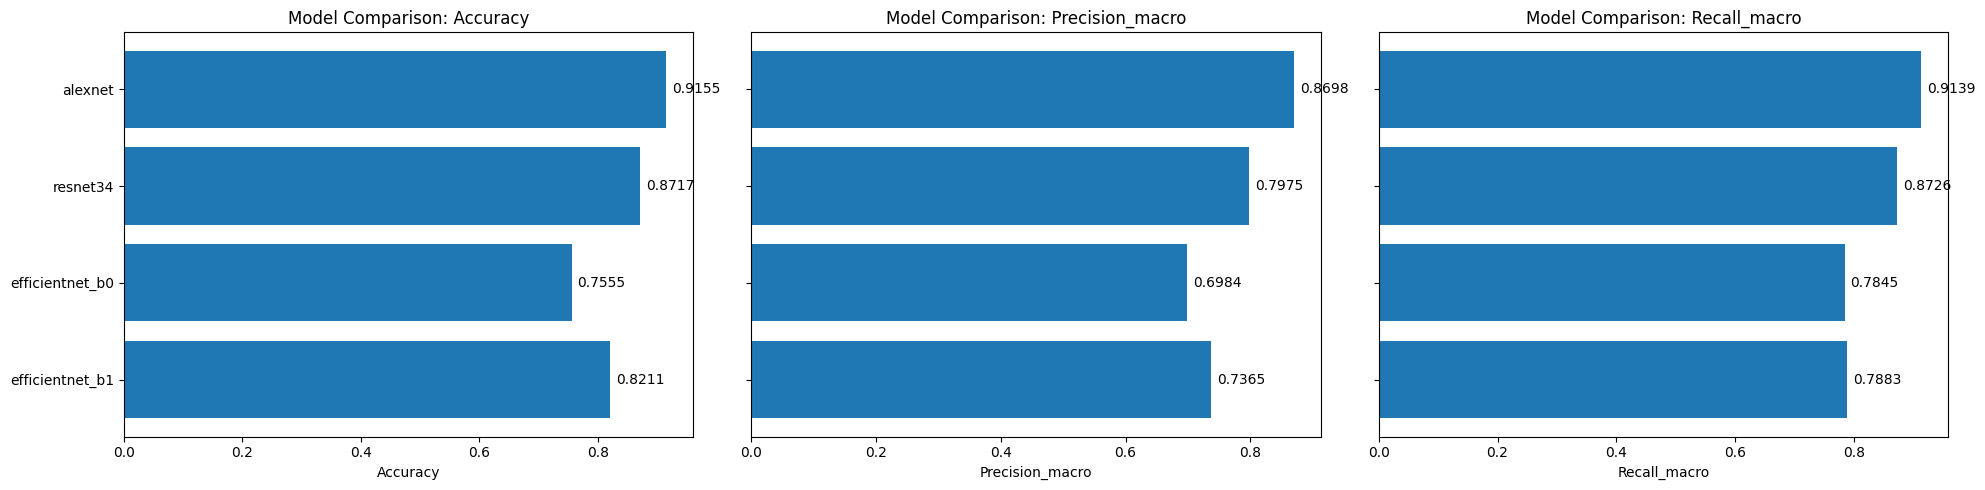

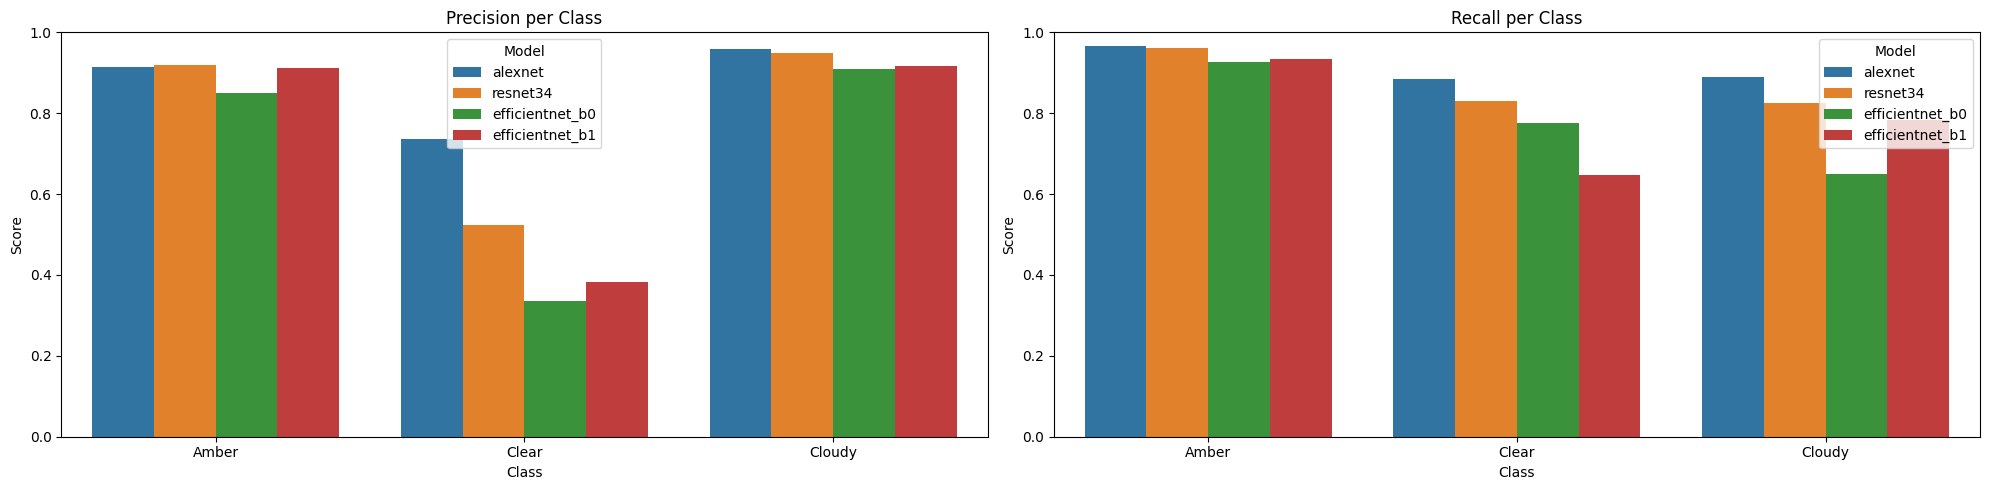

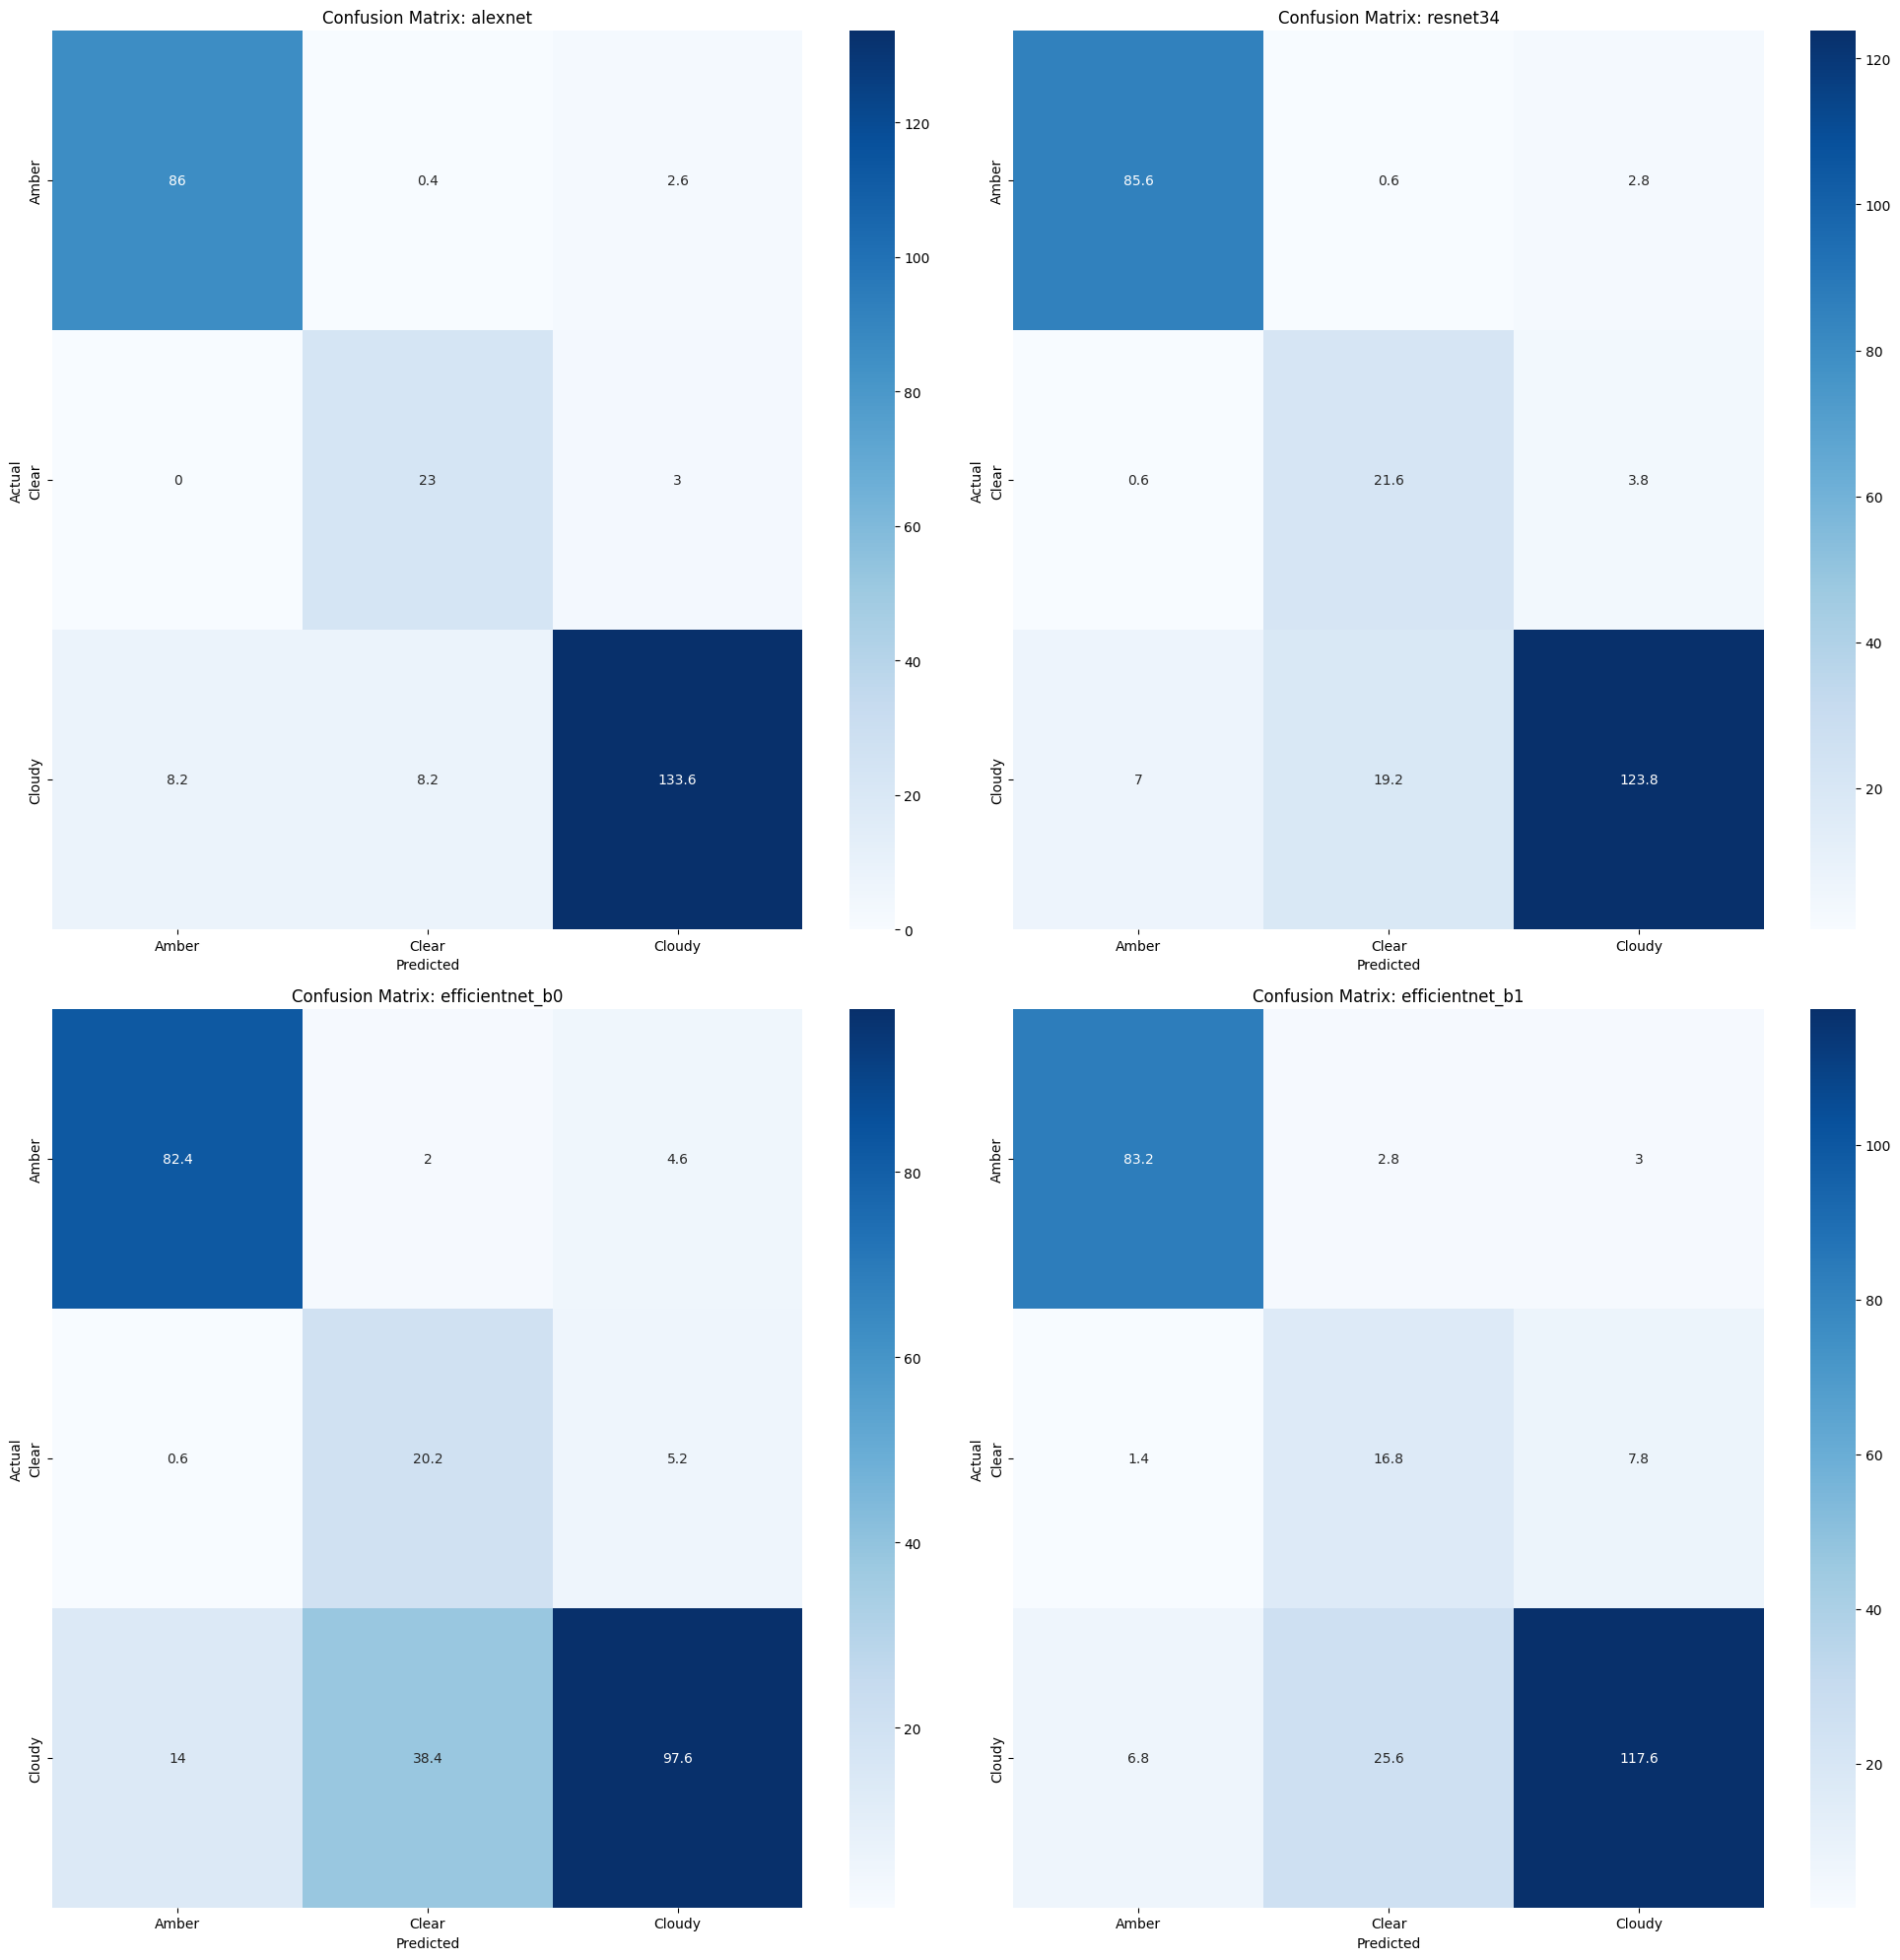

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Plotting metrics for each model
metrics_to_plot = ["accuracy", "precision_macro", "recall_macro"]
num_metrics = len(metrics_to_plot)
fig, axes = plt.subplots(1, num_metrics, figsize=(20, 5), sharey=True)

for i, metric in enumerate(metrics_to_plot):
    metric_values = average_results_df[metric]
    models = average_results_df['model']
    y_pos = np.arange(len(models))

    axes[i].barh(y_pos, metric_values, align='center')
    axes[i].set_yticks(y_pos)
    axes[i].set_yticklabels(models)
    axes[i].invert_yaxis()
    axes[i].set_xlabel(metric.capitalize())
    axes[i].set_title(f'Model Comparison: {metric.capitalize()}')

    for j in range(len(models)):
        axes[i].text(metric_values[j] + 0.01, y_pos[j], f'{metric_values[j]:.4f}', va='center')

plt.tight_layout()
plt.show()

# Plot precision and recall for each class
class_labels = ['Amber', 'Clear', 'Cloudy']

# Prepare precision and recall data for plotting
precision_data = []
recall_data = []
for i, row in average_results_df.iterrows():
    model_name = row['model']
    precision_per_class = row['precision_per_class']
    recall_per_class = row['recall_per_class']
    for j, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
        precision_data.append({'Model': model_name, 'Class': class_labels[j], 'Score': precision})
        recall_data.append({'Model': model_name, 'Class': class_labels[j], 'Score': recall})

precision_df = pd.DataFrame(precision_data)
recall_df = pd.DataFrame(recall_data)

# Plot class-wise precision and recall
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.barplot(x='Class', y='Score', hue='Model', data=precision_df, ax=axes[0])
axes[0].set_title('Precision per Class')
axes[0].set_ylim(0, 1)

sns.barplot(x='Class', y='Score', hue='Model', data=recall_df, ax=axes[1])
axes[1].set_title('Recall per Class')
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Plot confusion matrices for each model
num_models = len(average_results_df)
num_cols = 2
num_rows = (num_models + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
axes = axes.flatten()

for i, (index, row) in enumerate(average_results_df.iterrows()):
    cm = np.array(row['confusion_matrix'])
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=axes[i],
                xticklabels=class_labels, yticklabels=class_labels)
    axes[i].set_title(f'Confusion Matrix: {row["model"]}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
#TODO NEXT
"""
V - try to understand how can i improve the use of the dinov2 (for start it didnt recieve the best results)
V - compare more classifiers on the dinov2
- try more models that convert the images to embeddings and then with classifiers
- try to see if i can apply thresholds based on colors or other features to cluster or classify the trichomes
- try to see if i can apply some kind of clustering to the images and then classify them
- try to see if i can apply some kind of clustering to the embeddings and then classify them.
- check if i can do more transformations like i did in the time series course to the data in order to perform classification.
"""